# Income Classification


In [1]:
"""
Income Classification Script
Predict whether income >50K or <=50K using demographic and employment data.
All plots use seaborn for consistent styling.
"""
# =========================================================================
# Import Python Libraries
#
# ==========================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,confusion_matrix,
                             f1_score, roc_auc_score, roc_curve)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')
sns.set_style('ticks')
sns.set_palette('Set2')
sns.set_context('poster')
plt.rc('font', size=14, weight='bold')
plt.rc('axes', labelsize=14, titlesize=14, labelweight='bold')
plt.rc('legend', fontsize=14, title_fontsize=16)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
# Create output directory
output_dirs = ['plots_classification_outputs', 'models_classification_outputs']
for dir in output_dirs:
    os.makedirs(dir, exist_ok=True)




## Load Census Bureau Dataset


In [2]:
# =============================================================================
# Load and Explore Data
# =============================================================================
# Load the dataset columns
col_filename = 'census-bureau.columns'
# Load column names
with open(col_filename, 'r') as f:
    column_list = [line.strip() for line in f.readlines()]
print(column_list)

# Load the dataset
filename = 'census-bureau.data'
data = pd.read_csv(filename, header=None, names=column_list)
#data.duplicated()
# Remove duplicates
#data.drop_duplicates(inplace=True)

class_features =  ['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'wage per hour',
  'race', 'hispanic origin', 'sex', 'full or part time employment stat', 'capital gains', 'capital losses', 'dividends from stocks', 'tax filer stat',
 'detailed household and family stat', 'detailed household summary in household',  'country of birth self',
 'citizenship', 'own business or self employed', 'veterans benefits', 'weeks worked in year', 'weight', 'year', 'label']
df = data.drop_duplicates(ignore_index=True)

df['label'] = df['label'].replace({'- 50000.':'<=50K', '50000+.':'>50K'})
# Display basic info
print("Data loaded. Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
# print("\nFirst 5 rows:")
# print(df.head())


['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'wage per hour', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'capital gains', 'capital losses', 'dividends from stocks', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'weight', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'num persons worked for employer', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'own business or self employed', "fill inc questionnaire for veteran's admin", 'veterans benefits', 'weeks worked 

In [3]:
# Dataset Summary
print("\nDataset Summary:")
print(df.info())

# Dataset Summary Statistics
print("\nSummary Statistics:")
print(df.describe(include='all'))


# Clean target
# Map label to binary
df['income'] = df['label'].apply(lambda x: 1 if x.strip() == '>50K' else 0)
print(df['income'].value_counts(normalize=True))

# Replace '?' , 'Not in universe or children', 'Not in universe under 1 year old', and 'Not in universe' with NaN for easier handling
na_values = ['?', 'Not in universe',
              'Not in universe or children', 'Not in universe under 1 year old']
df.replace(na_values, np.nan, inplace=True)



Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196294 entries, 0 to 196293
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         196294 non-null  int64  
 1   class of worker                             196294 non-null  object 
 2   detailed industry recode                    196294 non-null  int64  
 3   detailed occupation recode                  196294 non-null  int64  
 4   education                                   196294 non-null  object 
 5   wage per hour                               196294 non-null  int64  
 6   enroll in edu inst last wk                  196294 non-null  object 
 7   marital stat                                196294 non-null  object 
 8   major industry code                         196294 non-null  object 
 9   major occupation code                       196294 n

In [4]:
df.describe()


age  detailed industry recode  detailed occupation recode  \
count  196294.000000             196294.000000               196294.000000   
mean       34.929468                 15.603187                   11.490468   
std        22.210001                 18.106401                   14.498128   
min         0.000000                  0.000000                    0.000000   
25%        16.000000                  0.000000                    0.000000   
50%        34.000000                  1.000000                    2.000000   
75%        50.000000                 33.000000                   26.000000   
max        90.000000                 51.000000                   46.000000   

       wage per hour  capital gains  capital losses  dividends from stocks  \
count  196294.000000  196294.000000   196294.000000          196294.000000   
mean       56.336505     441.870037       37.927593             200.722386   
std       277.054333    4735.677027      274.081174            2000.130616   
min         0.000000       0.000000        0.000000               0.000000   
25%         0.000000       0.000000        0.000000               0.000000   
50%         0.000000       0.000000        0.000000               0.000000   
75%         0.000000       0.000000        0.000000               0.000000   
max      9999.000000   99999.000000     4608.000000           99999.000000   

              weight  num persons worked for employer  \
count  196294.000000                    196294.000000   
mean     1743.267584                         1.988105   
std       996.945985                         2.371018   
min        37.870000                         0.000000   
25%      1061.530000                         0.000000   
50%      1620.175000                         1.000000   
75%      2194.060000                         4.000000   
max     18656.300000                         6.000000   

       own business or self employed  veterans benefits  weeks worked in year  \
count                  196294.000000      196294.000000         196294.000000   
mean                        0.178304           1.538183             23.553889   
std                         0.557739           0.836813             24.428588   
min                         0.000000           0.000000              0.000000   
25%                         0.000000           2.000000              0.000000   
50%                         0.000000           2.000000             12.000000   
75%                         0.000000           2.000000             52.000000   
max                         2.000000           2.000000             52.000000   

                year         income  
count  196294.000000  196294.000000  
mean       94.499328       0.063079  
std         0.500001       0.243105  
min        94.000000       0.000000  
25%        94.000000       0.000000  
50%        94.000000       0.000000  
75%        95.000000       0.000000  
max        95.000000       1.000000

In [5]:
print("\nMissing Values:\n", df.isnull().sum())

# Plotting missing values
plt.figure(figsize=(8, 6))
sns.countplot(x=df.isnull().sum(), palette='Set2')
plt.title('Missing Values Count')
plt.ylabel("Number of Columns")
plt.savefig(f'{output_dirs[0]}/missing_distribution.png')
plt.close()



Missing Values:
 age                                                0
class of worker                                97029
detailed industry recode                           0
detailed occupation recode                         0
education                                          0
wage per hour                                      0
enroll in edu inst last wk                    183762
marital stat                                       0
major industry code                            97467
major occupation code                          97467
race                                               0
hispanic origin                                  870
sex                                                0
member of a labor union                       177232
reason for unemployment                       190226
full or part time employment stat                  0
capital gains                                      0
capital losses                                     0
dividends from stocks       

## Exploratory Data Analysis
### Univariate Analysis

In [6]:
print("\n=== Exploratory Data Analysis ===")
def histogram_boxplot(data, feature, figsize=(10, 8), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    fig, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram
    plt.suptitle(f'Distribution of {feature}', fontsize=16, fontweight='bold')
    return fig

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        fig = plt.figure(figsize=(count + 1, 8))
        n = count
    else:
        fig = plt.figure(figsize=(n + 1, 8))

    plt.xticks(rotation=75, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage
    top_col = '' if count < n else f'(Top {n} categories)'
    plt.title(f'Distribution of {feature} {top_col}', fontsize=16, fontweight='bold')
    #plt.show()  # show the plot
    return fig



=== Exploratory Data Analysis ===


income
0    0.936921
1    0.063079
Name: proportion, dtype: float64


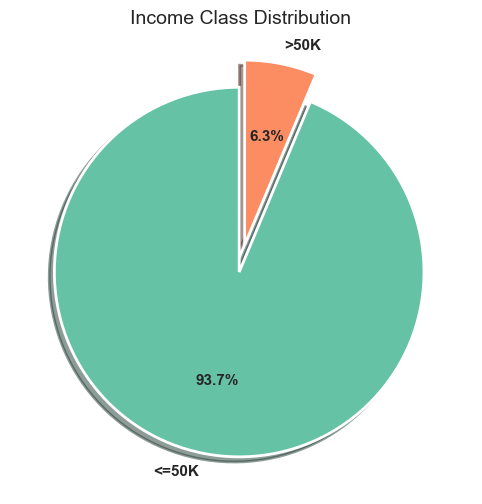

Target Class distribution saved.


In [7]:
# Target distribution
# Map label to binary income feature
df['income'] = df['label'].apply(lambda x: 1 if x.strip() == '>50K' else 0)
print(df['income'].value_counts(normalize=True))
explode = (0.05, 0.1)

plt.figure(figsize=(9,6))
df['income'].value_counts().plot.pie(autopct='%1.1f%%', labels=['<=50K', '>50K'], shadow=True, startangle=90,
              textprops={'fontsize': 11, 'fontweight': 'bold'}, explode=explode)
plt.title('Income Class Distribution')
plt.ylabel('')
plt.savefig(f'{output_dirs[0]}/target_distribution.png')
plt.show()
plt.close()
print("Target Class distribution saved.")

backup_df = df.copy( )


Top 20 missing columns (% missing):
fill inc questionnaire for veteran's admin    98.989271
reason for unemployment                       96.908719
enroll in edu inst last wk                    93.615699
state of previous residence                   92.345665
migration prev res in sunbelt                 91.985491
region of previous residence                  91.985491
member of a labor union                       90.289056
family members under 18                       73.441369
migration code-move within reg                50.655649
live in this house 1 year ago                 50.655649
migration code-change in msa                  50.655649
migration code-change in reg                  50.655649
major occupation code                         49.653581
major industry code                           49.653581
class of worker                               49.430446
country of birth father                        3.414776
country of birth mother                        3.111150
country of b

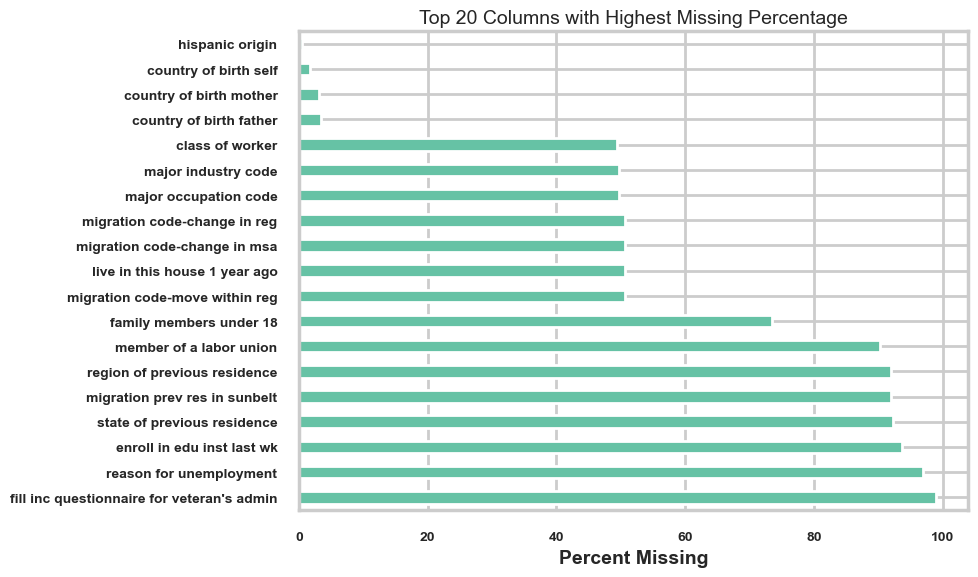

In [8]:
# Missing data analysis
# Replace '?' , 'Not in universe or children', 'Not in universe under 1 year old', and 'Not in universe' with NaN for easier handling
na_values = ['?', 'Not in universe',
              'Not in universe or children', 'Not in universe under 1 year old']
df.replace(na_values, np.nan, inplace=True)

missing_frac = df.isnull().mean() * 100
missing_frac = missing_frac[missing_frac > 0].sort_values(ascending=False)
top_missing = 20
print(f"Top {top_missing} missing columns (% missing):")
print(missing_frac.head(top_missing))

# Plot missing percentages
plt.figure(figsize=(10,6))
missing_frac.head(top_missing).plot(kind='barh')
plt.xlabel('Percent Missing')
plt.title(f'Top {top_missing} Columns with Highest Missing Percentage')
plt.tight_layout()
plt.savefig(f'{output_dirs[0]}/missing_percentages.png')
plt.show()
plt.close()


Columns with >70% missing:
 Series([], dtype: float64)
Dropped 0 columns with >70% missing.
Dropped columns: []
Remaining columns: ['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'wage per hour', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'full or part time employment stat', 'capital gains', 'capital losses', 'dividends from stocks', 'tax filer stat', 'detailed household and family stat', 'detailed household summary in household', 'weight', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'num persons worked for employer', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'own business or self employed', 'veterans benefits', 'weeks worked in year', 'year', 'label', 'income']

Missing Values After Dropping:
 age                                            0
cla

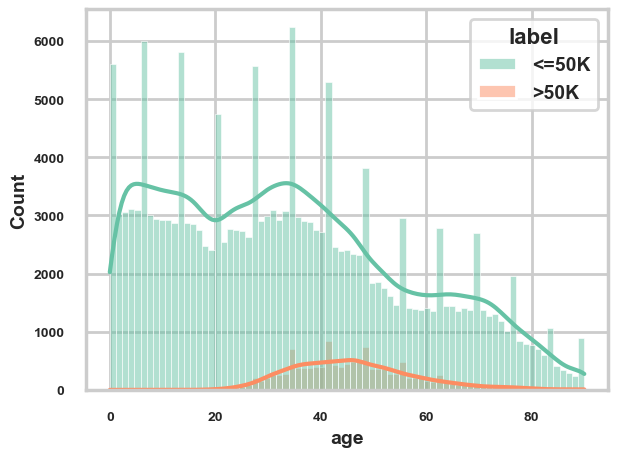

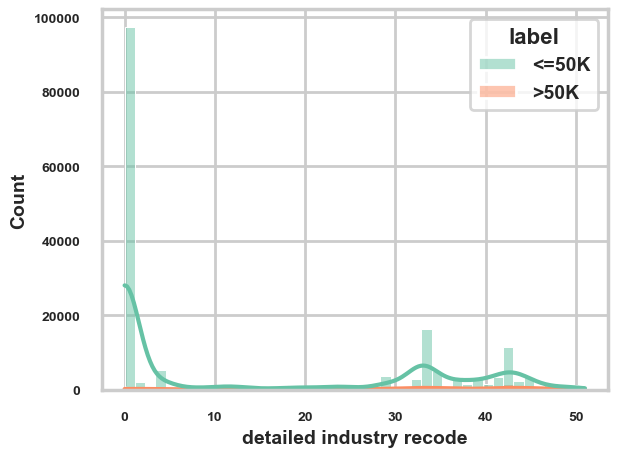

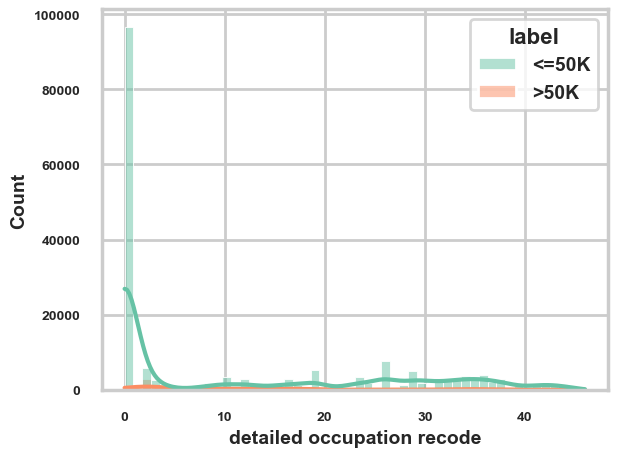

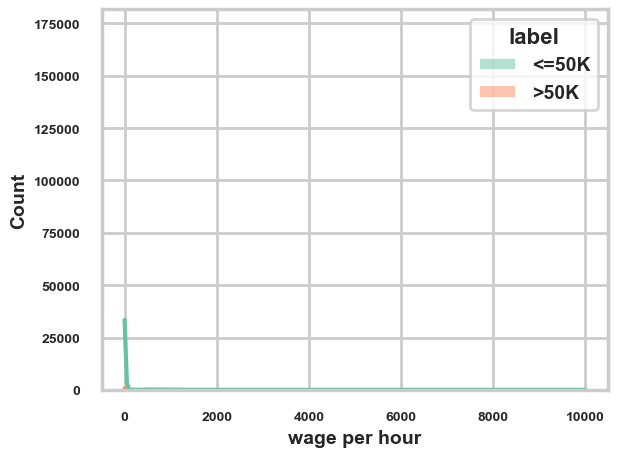

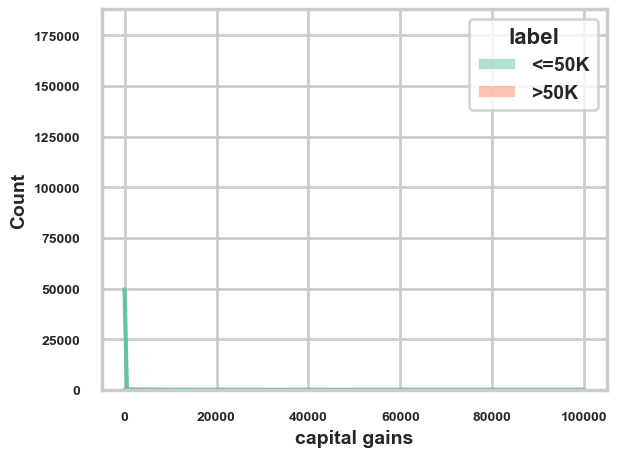

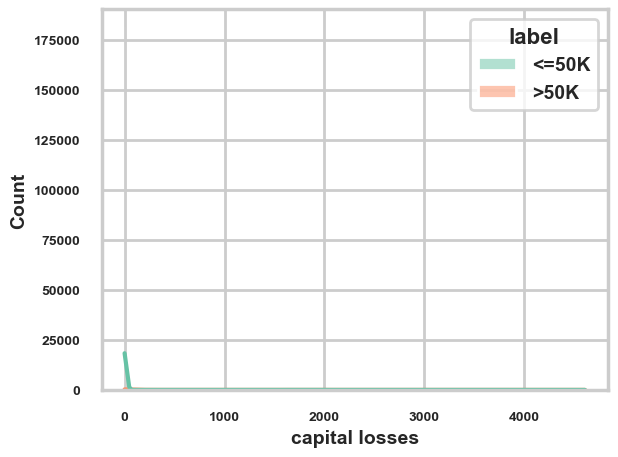

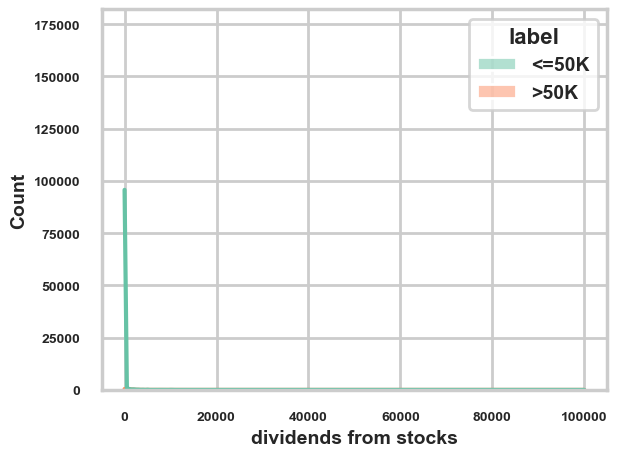

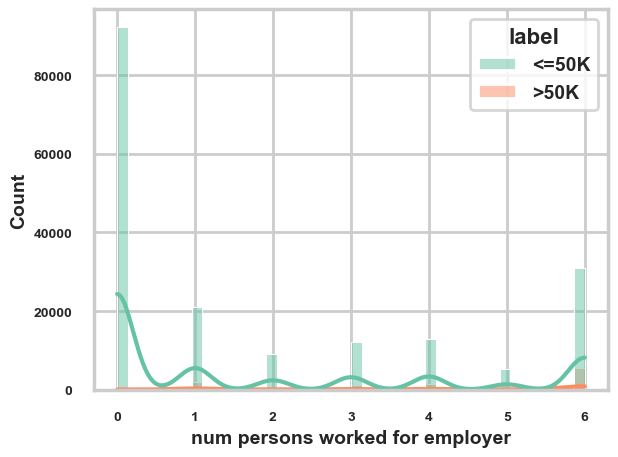

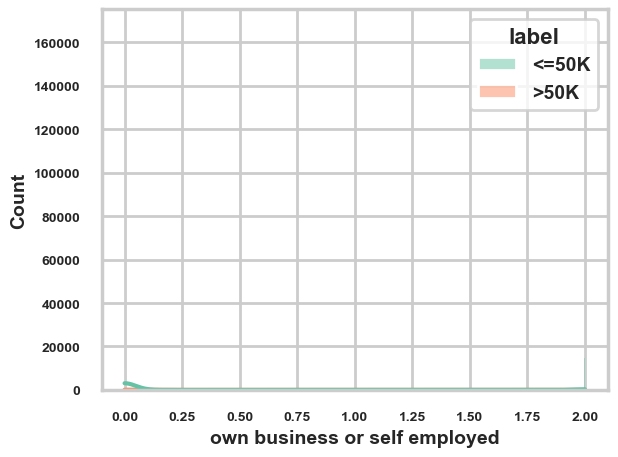

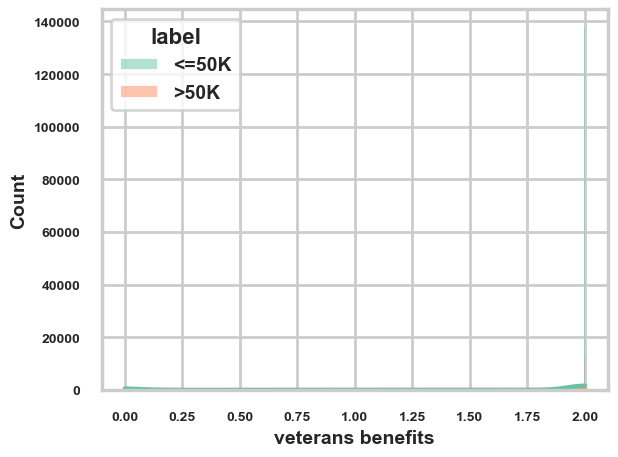

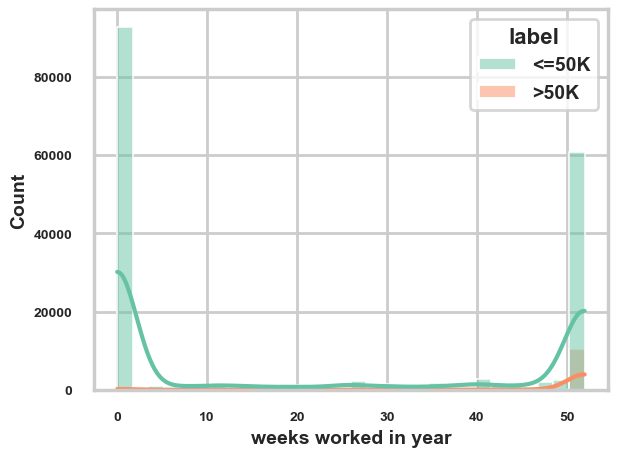

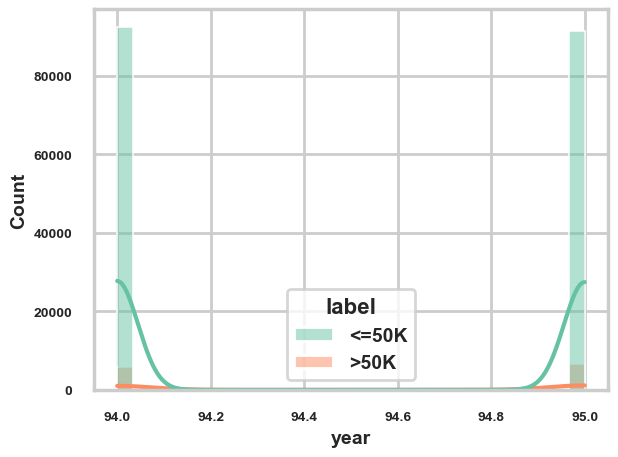

In [13]:
# Drop columns with >40% missing
fraction = 70
missing_frac = (df.isnull().mean()*100).sort_values(ascending=False)
print(f"Columns with >{fraction}% missing:\n", missing_frac[missing_frac > fraction])
high_missing_cols = missing_frac[missing_frac > fraction].index.tolist()
# country_col = ['country of birth father', 'country of birth mother', 'country of birth self']
df.drop(columns=high_missing_cols, inplace=True)
print(f"Dropped {len(high_missing_cols)} columns with >{fraction}% missing.")
print(f"Dropped columns: {high_missing_cols}")
print("Remaining columns:", df.columns.tolist())
print("\nMissing Values After Dropping:\n", df.isnull().sum())

# Numeric features distribution
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove target and weight if present
numeric_cols = [c for c in numeric_cols if c not in ['income', 'weight']]

num_rows = len(numeric_cols)//3 + 1 if len(numeric_cols) % 3 != 0 else len(numeric_cols)//3

for i, col in enumerate(numeric_cols):
    #histogram_boxplot(df, col, kde=True)
    sns.histplot(data=df, x=col, hue='label', stat="count",kde=True) #"count", "density", "percent", "probability", "proportion", "frequency"
    col_name = col.replace(' ', '_')
    plt.tight_layout()
    plt.savefig(f'{output_dirs[0]}/numeric_distributions_{col_name}.png')
    plt.show()
    plt.close()


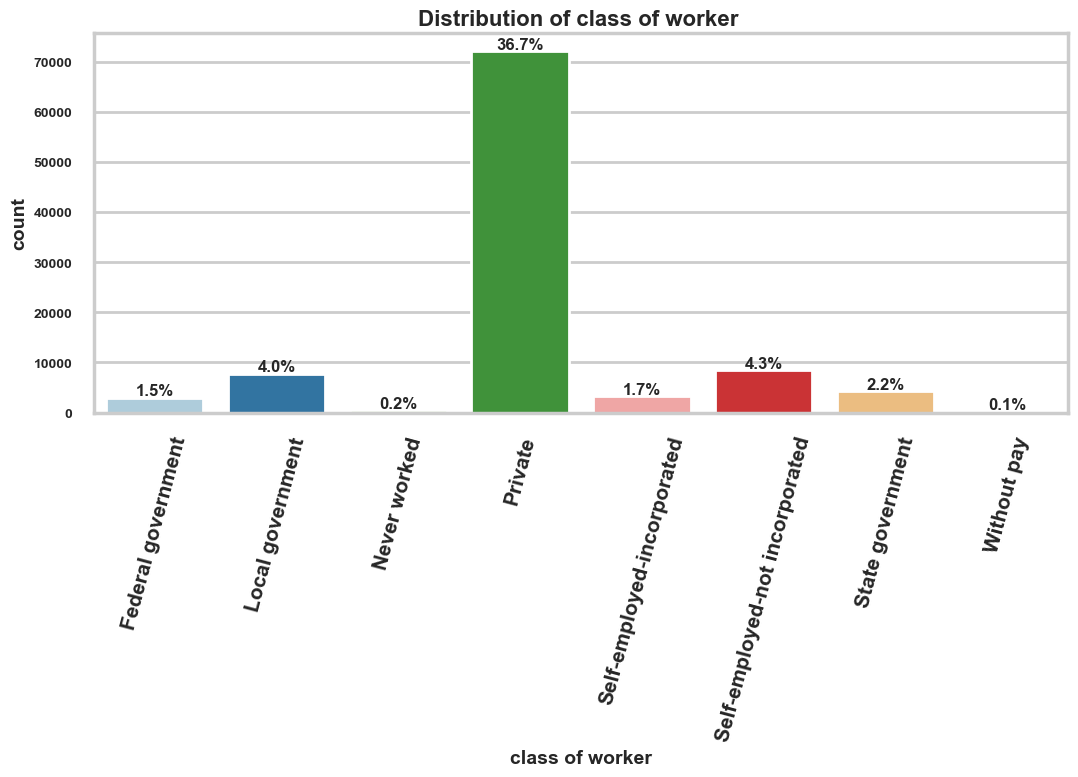

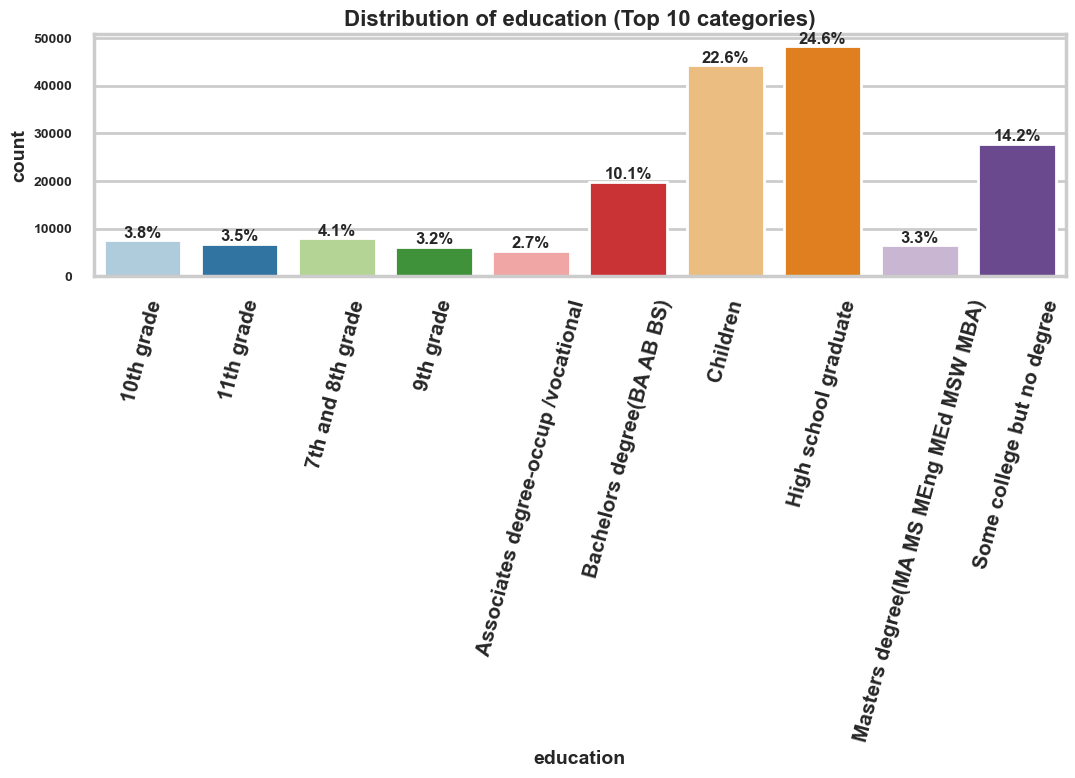

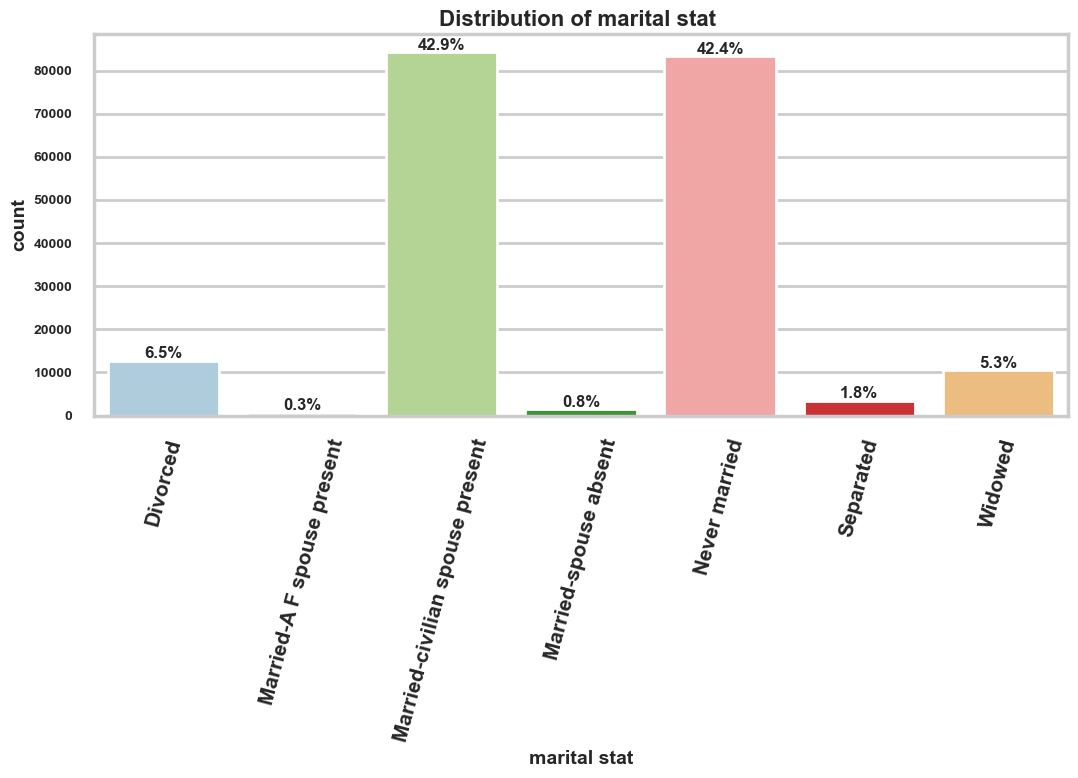

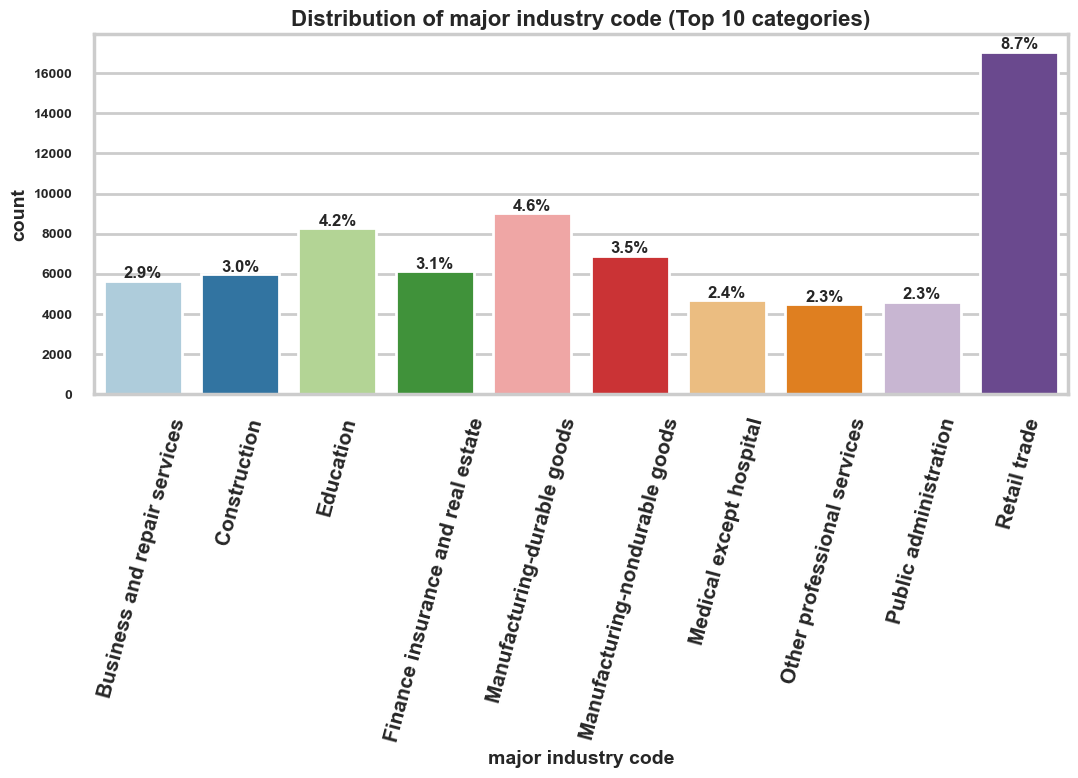

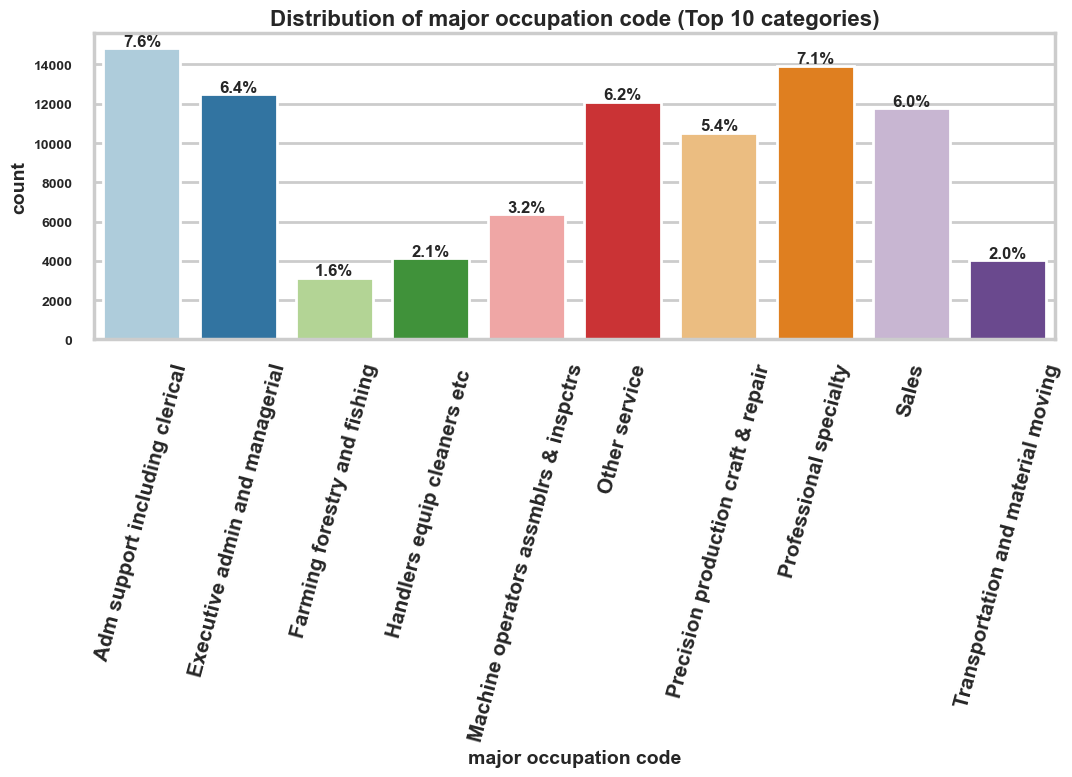

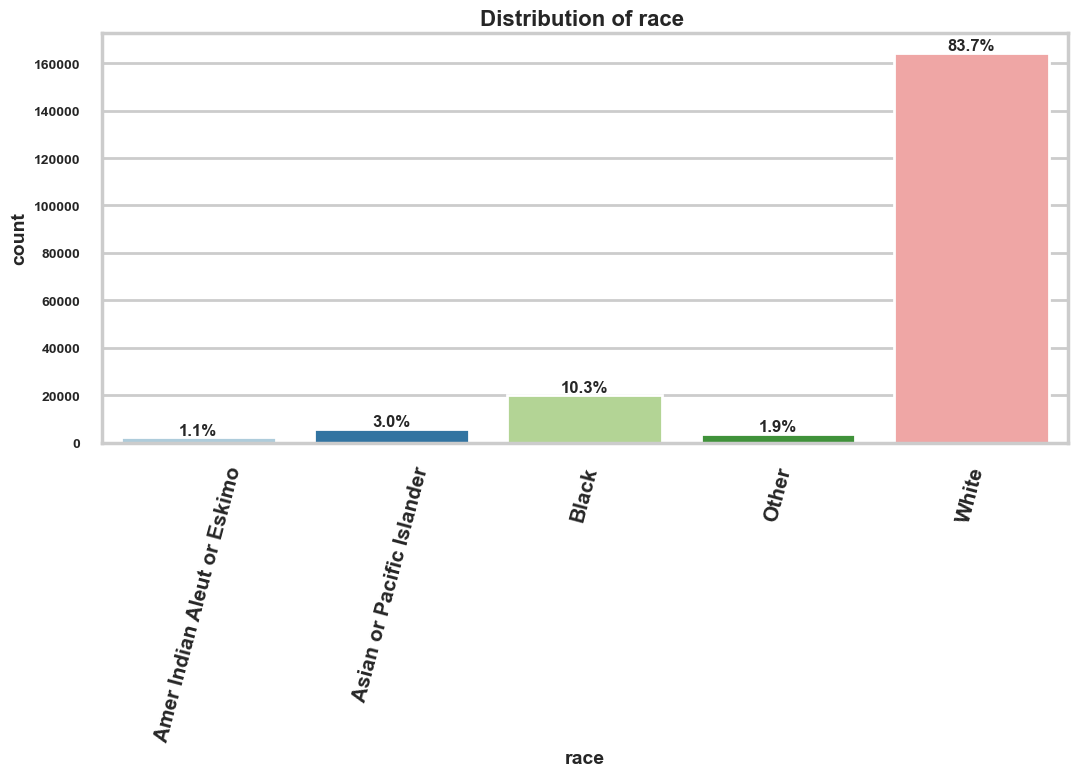

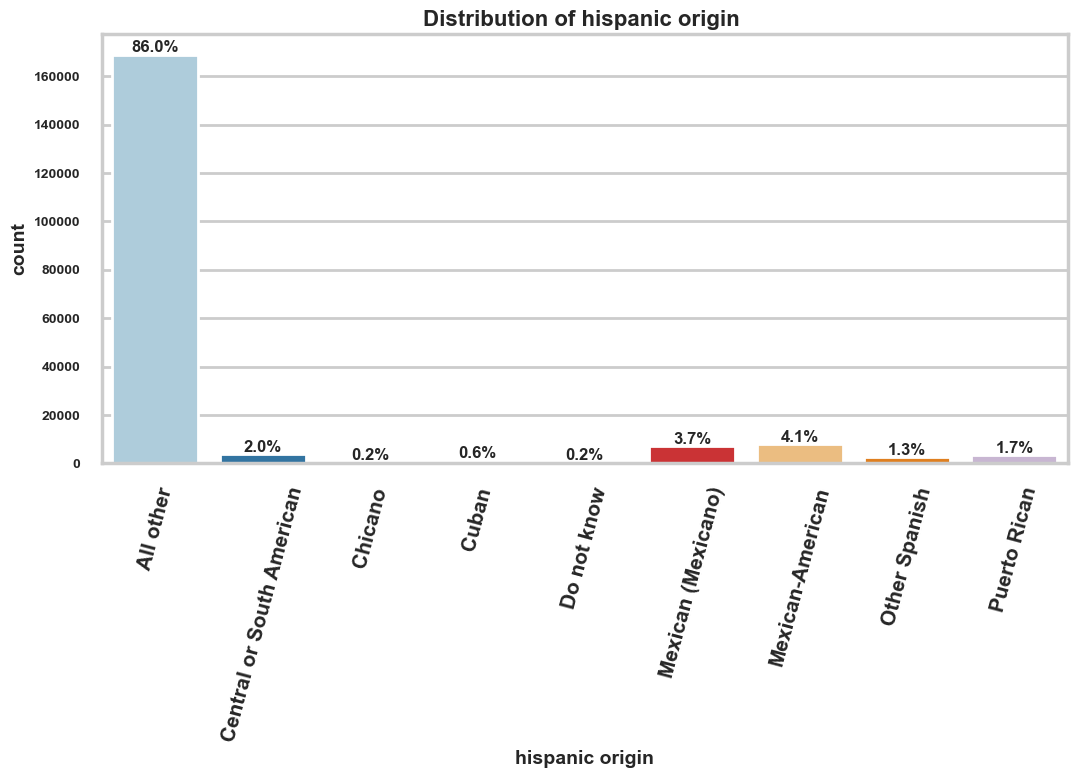

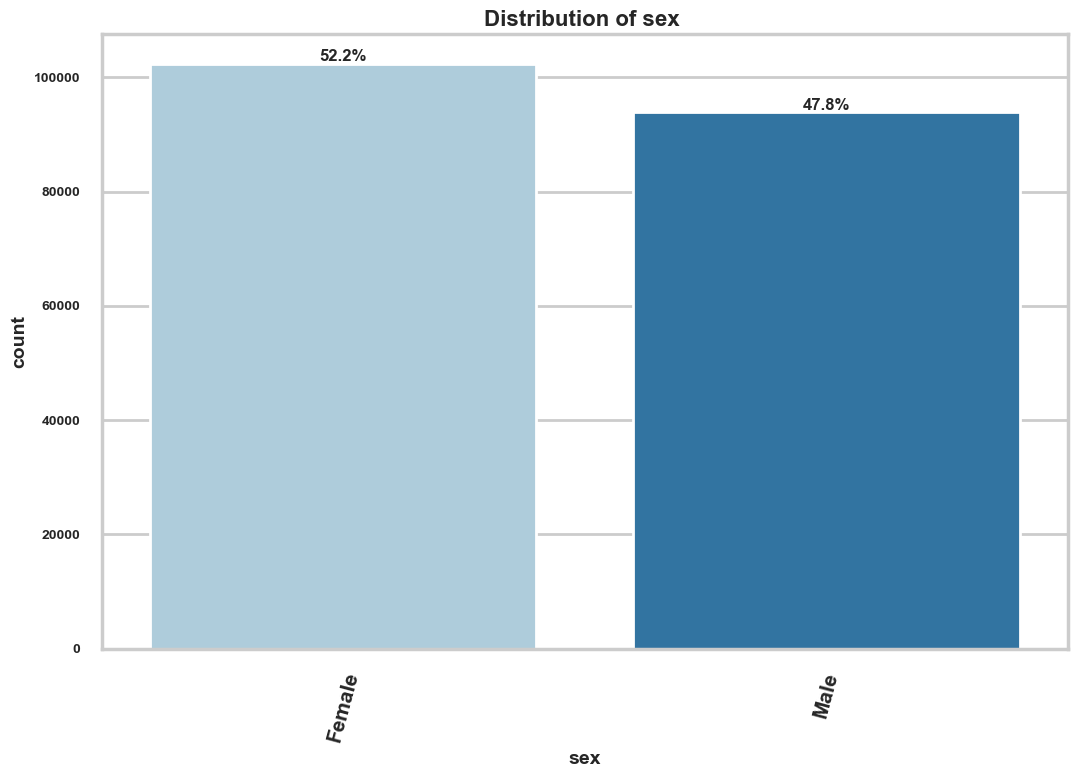

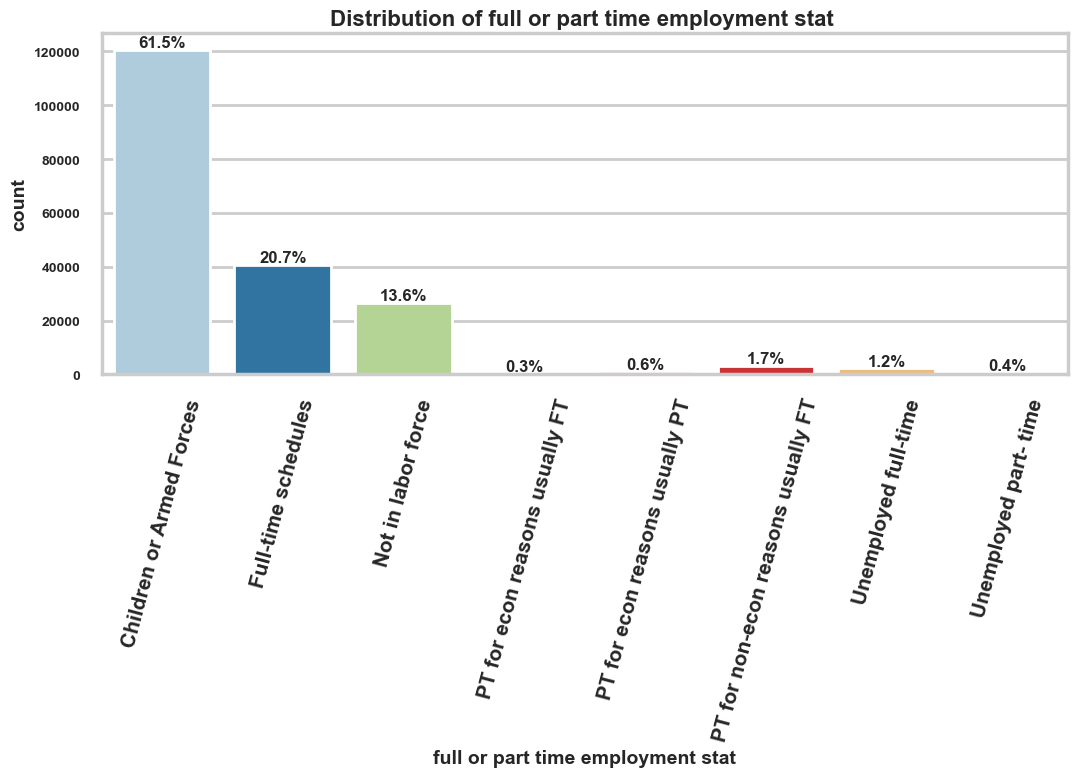

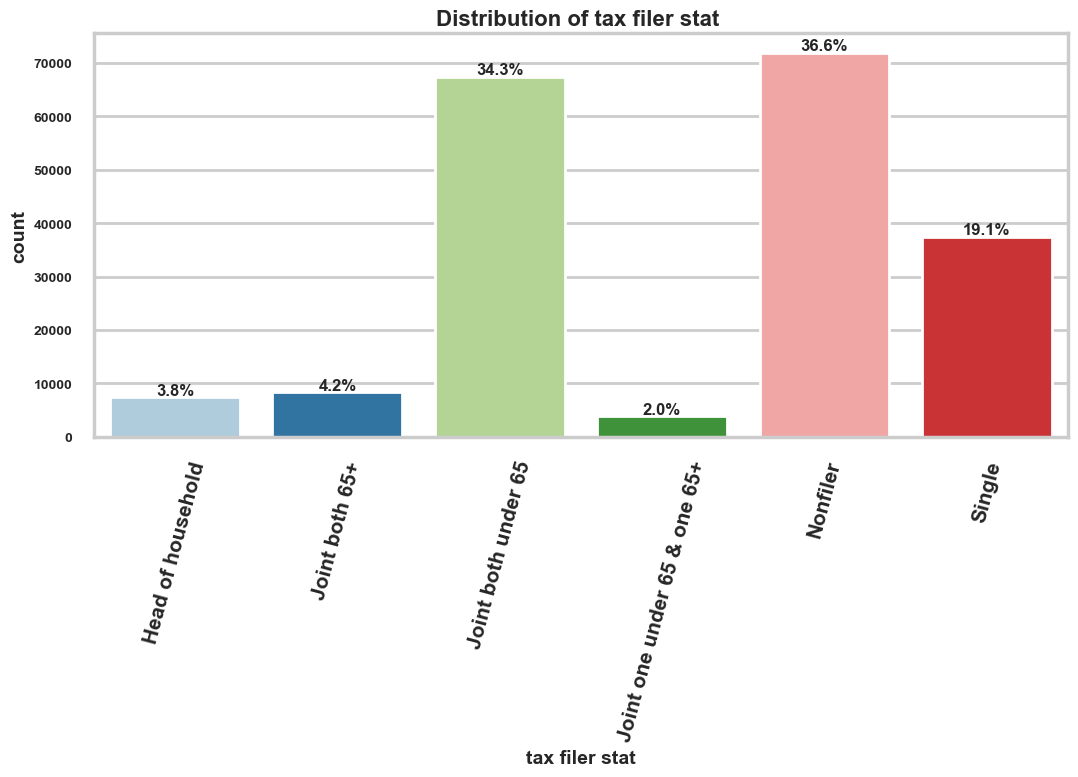

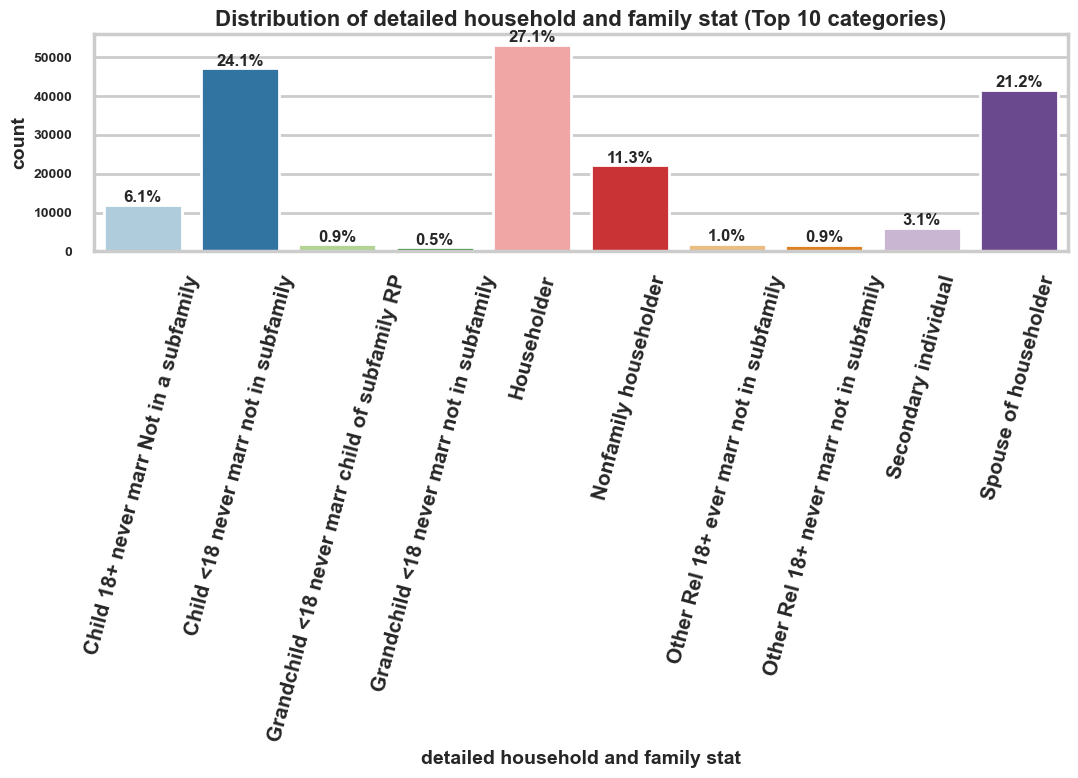

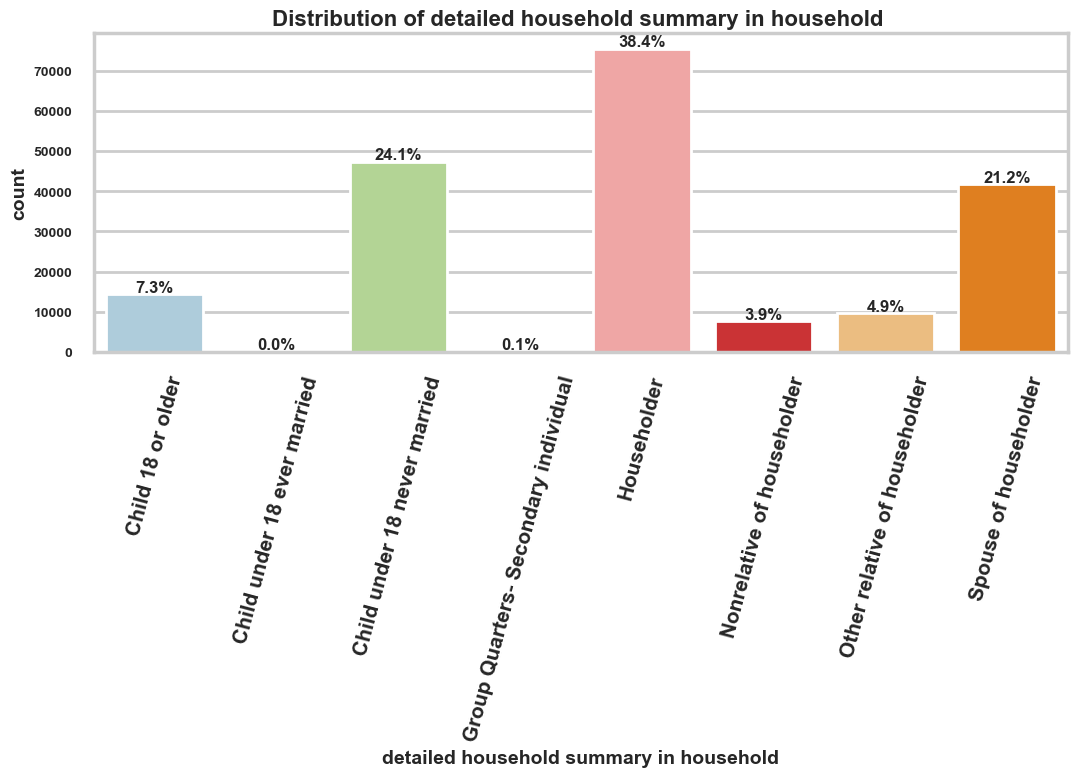

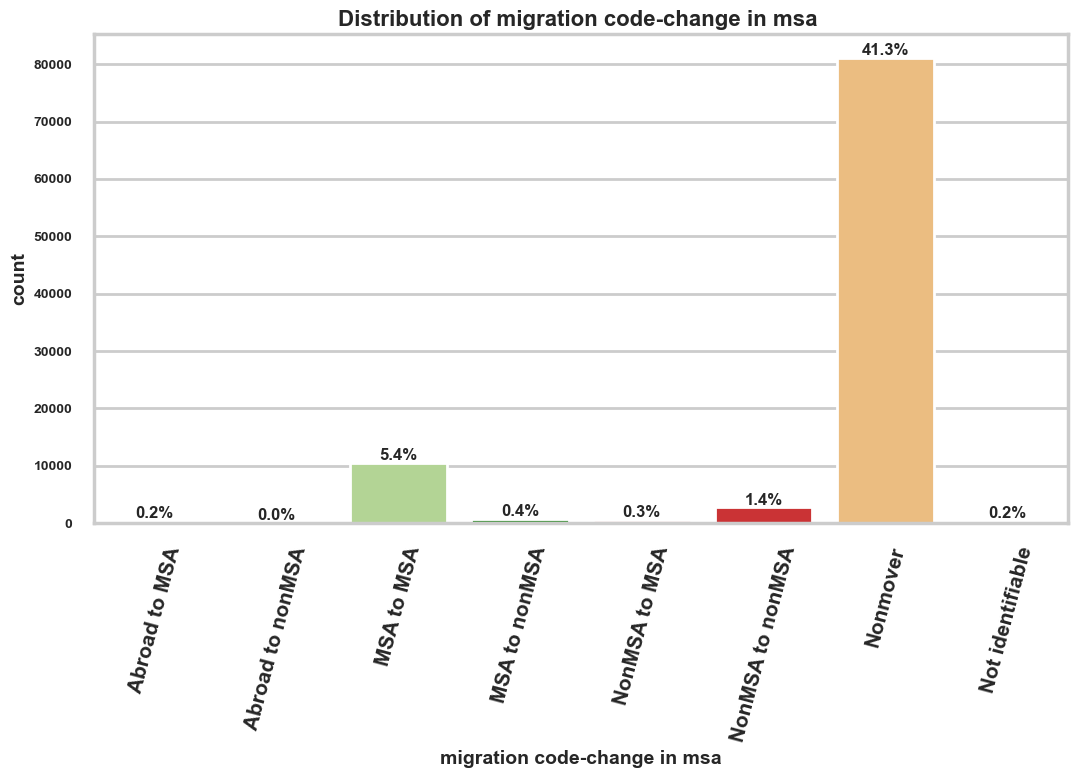

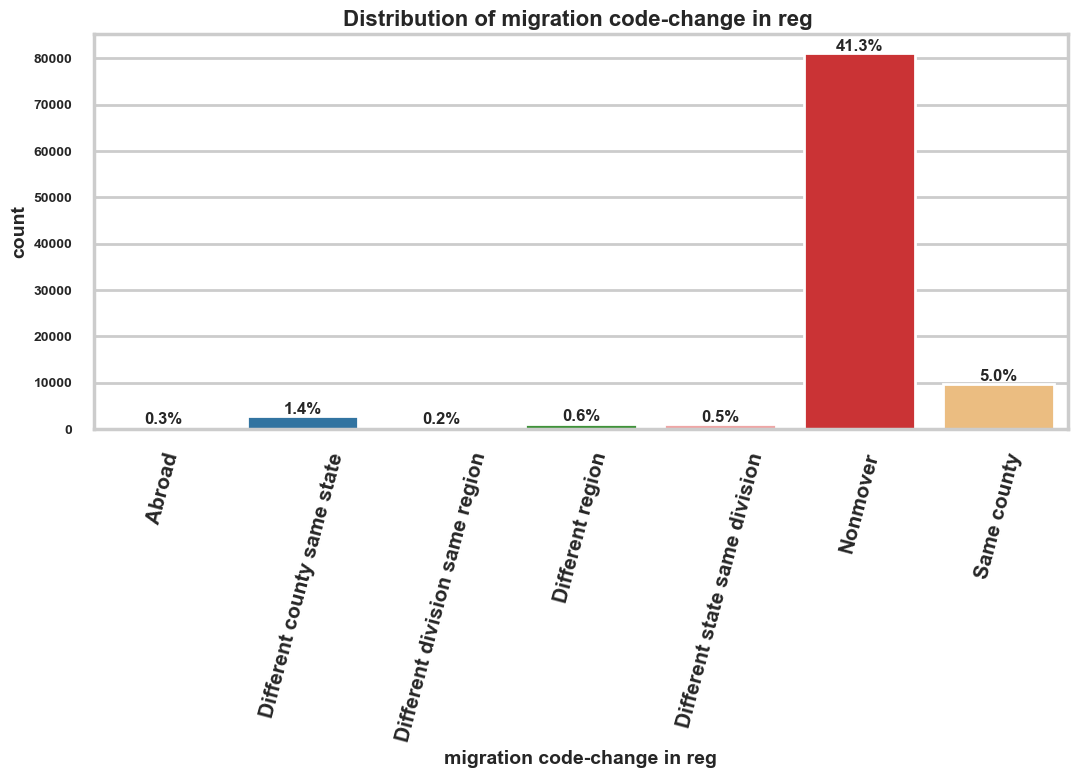

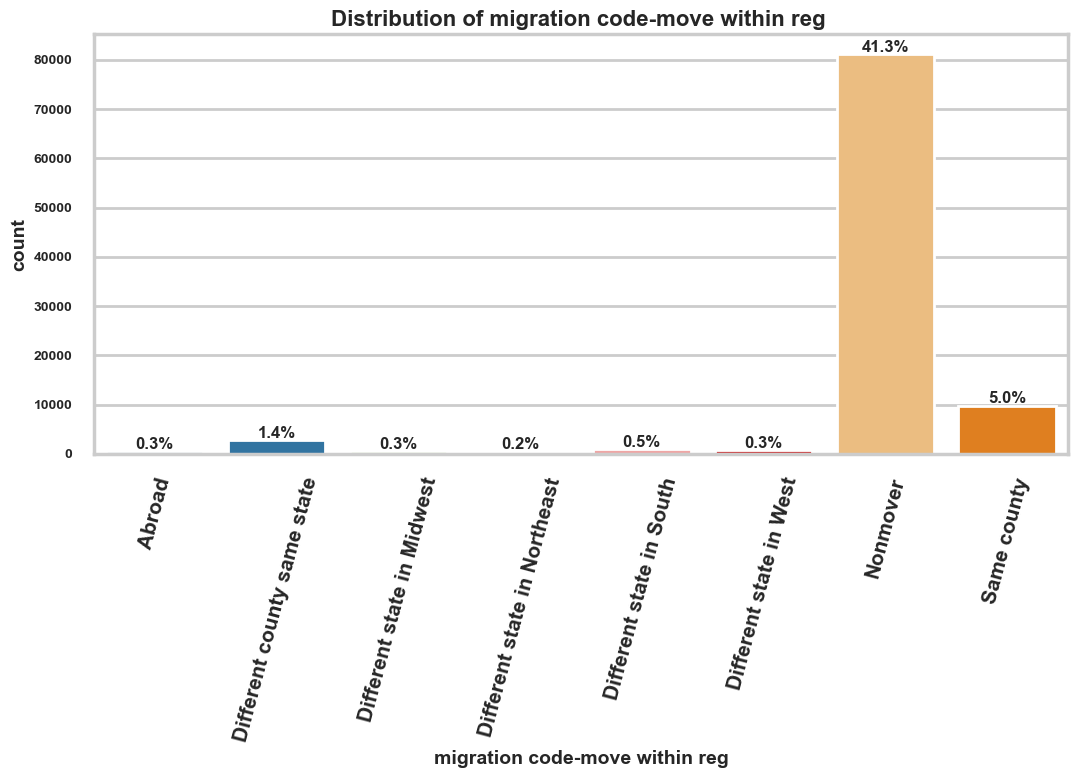

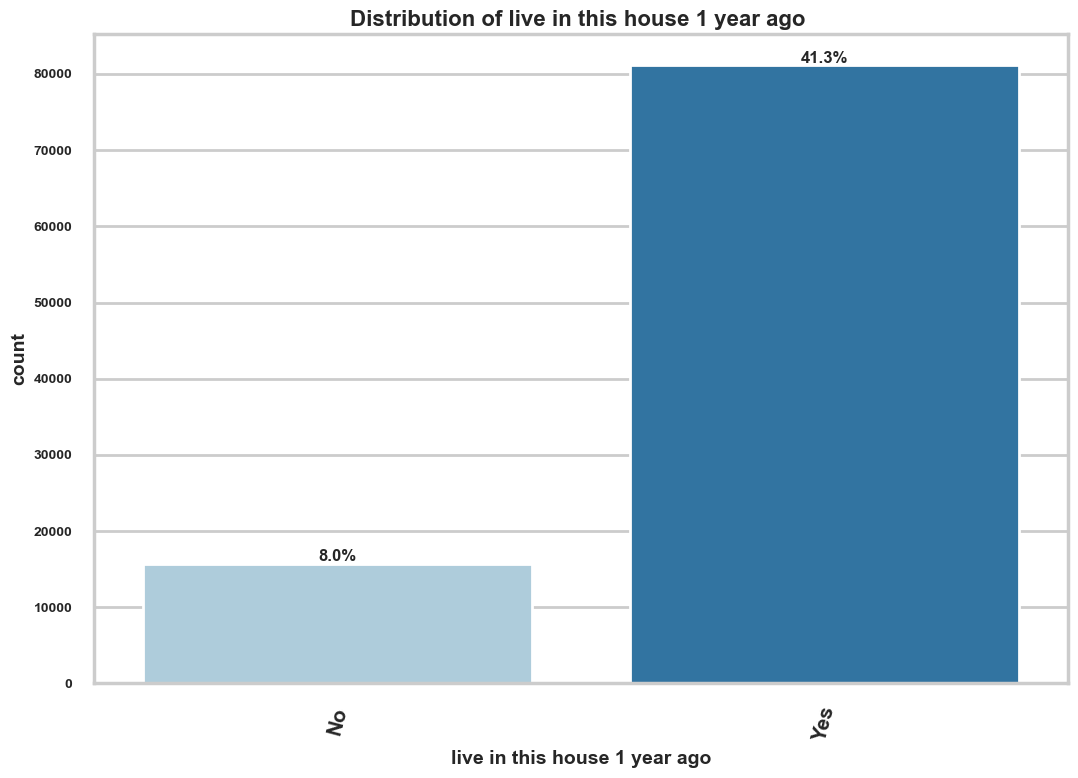

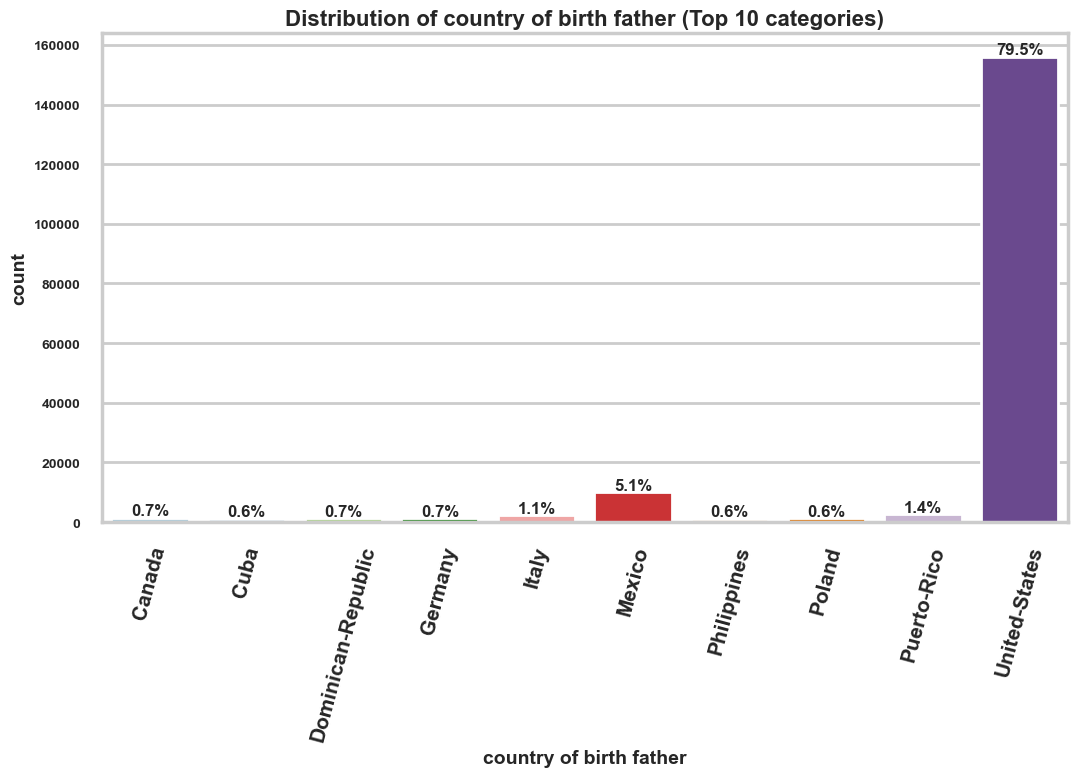

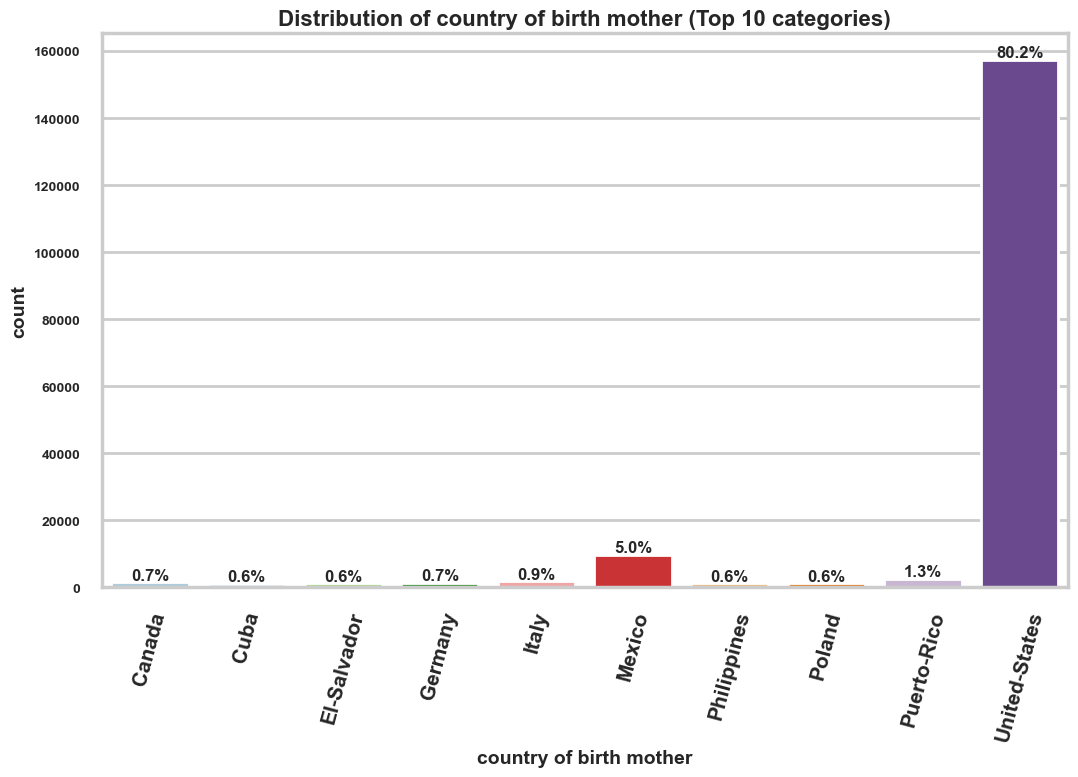

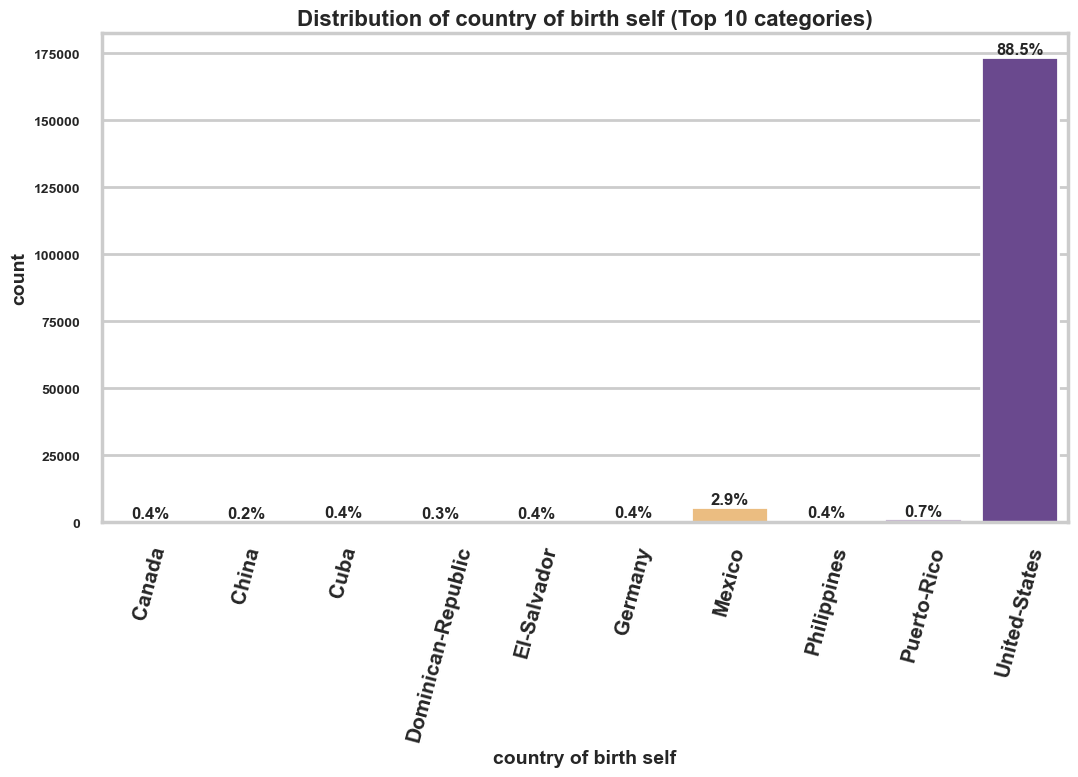

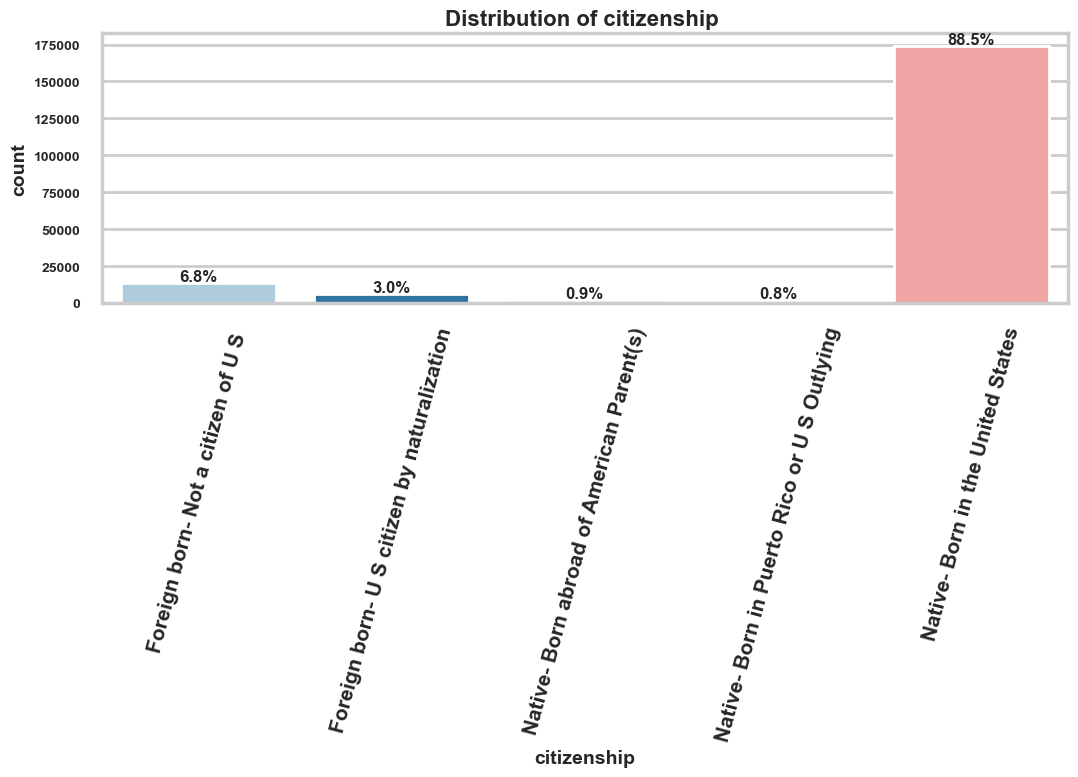

In [14]:
# Categorical features - top categories
from matplotlib.pyplot import axes


categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'label' in categorical_cols:
    categorical_cols.remove('label')

for i, col in enumerate(categorical_cols):
    labeled_barplot(df, col, perc=True, n=10)
    #plt.tick_params(axis='x', rotation=25)
    col_name = col.replace(' ', '_')
    plt.tight_layout()
    plt.savefig(f'{output_dirs[0]}/categorical_top10_{col_name}.png')
    plt.show()
    plt.close()


### Bivariate Analysis: Numeric vs Target (Label)


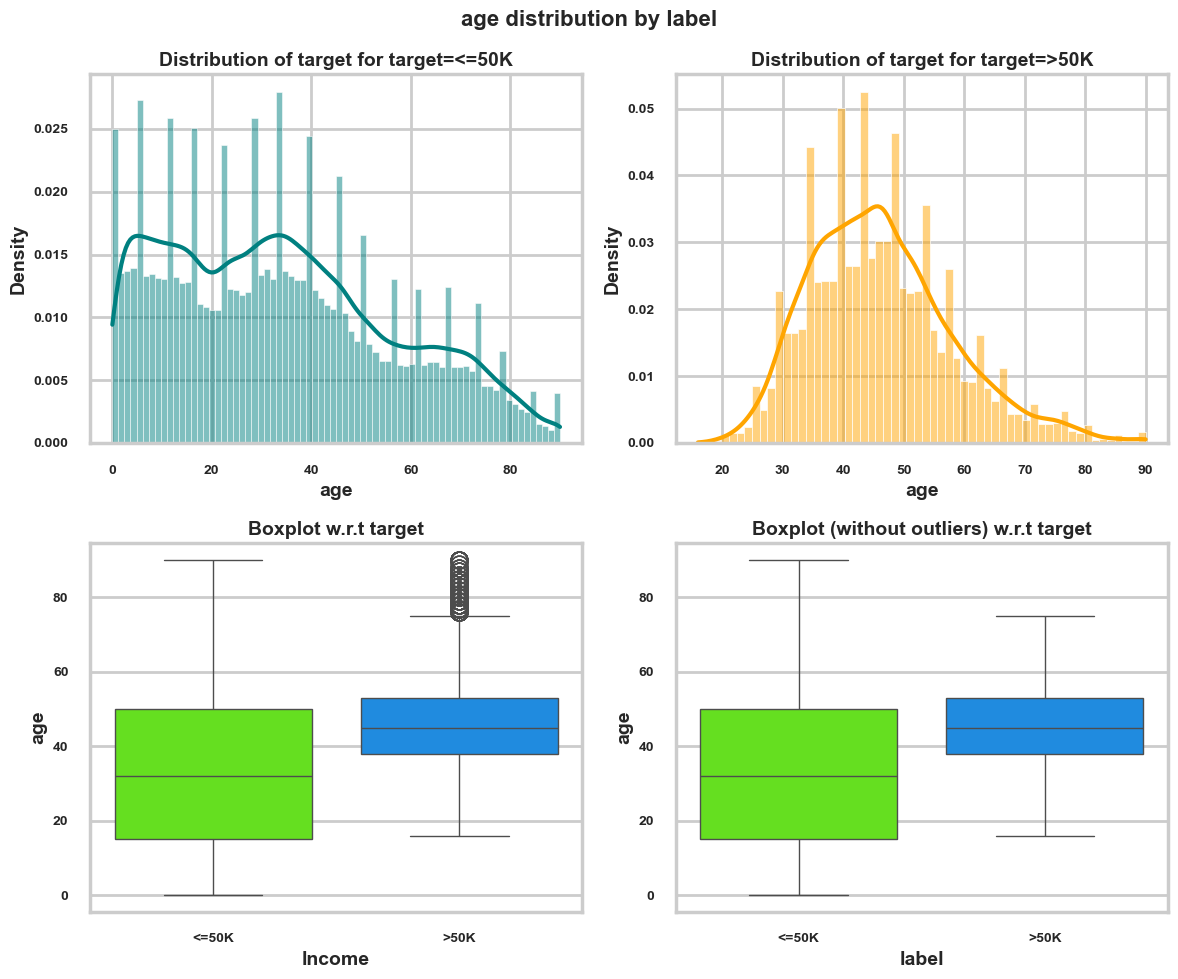

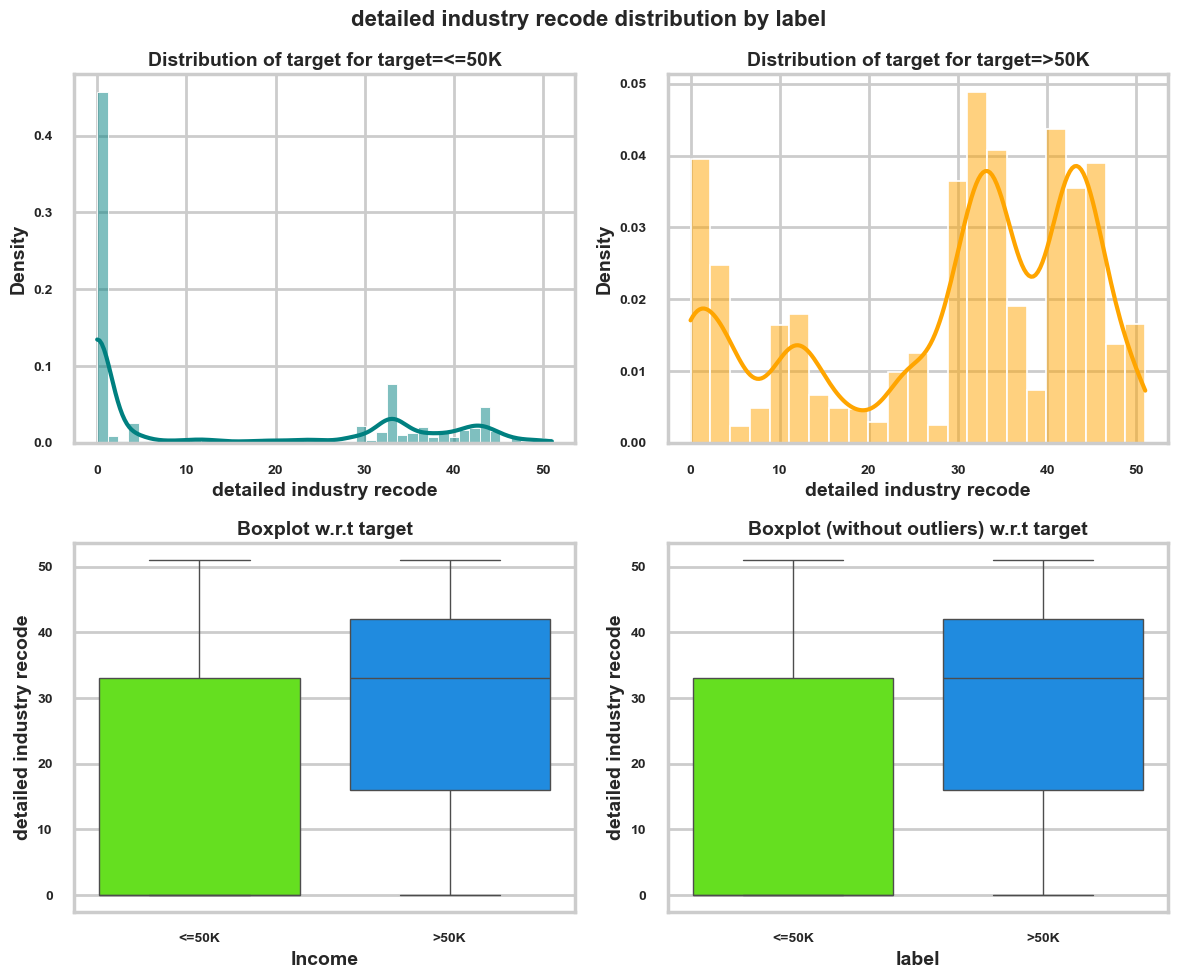

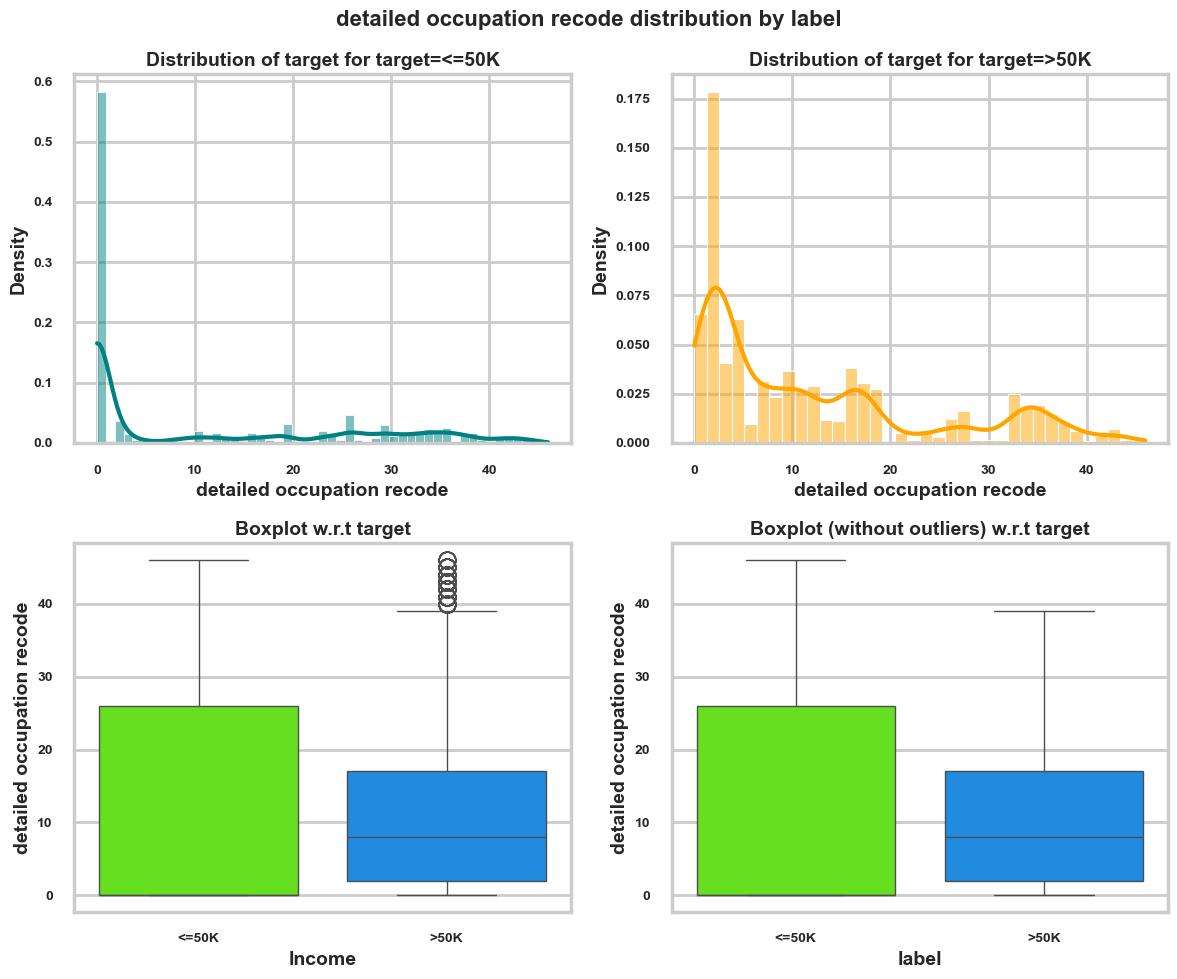

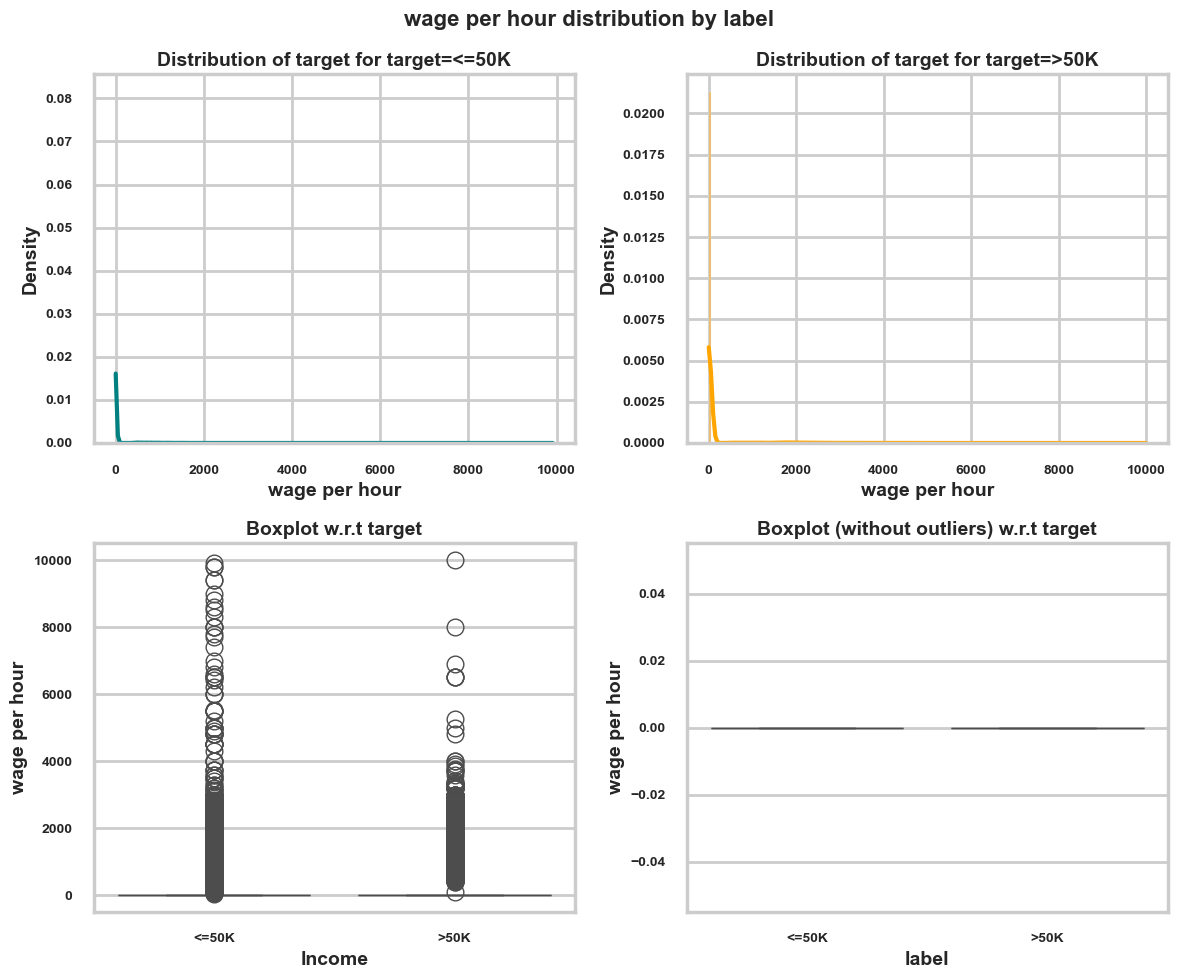

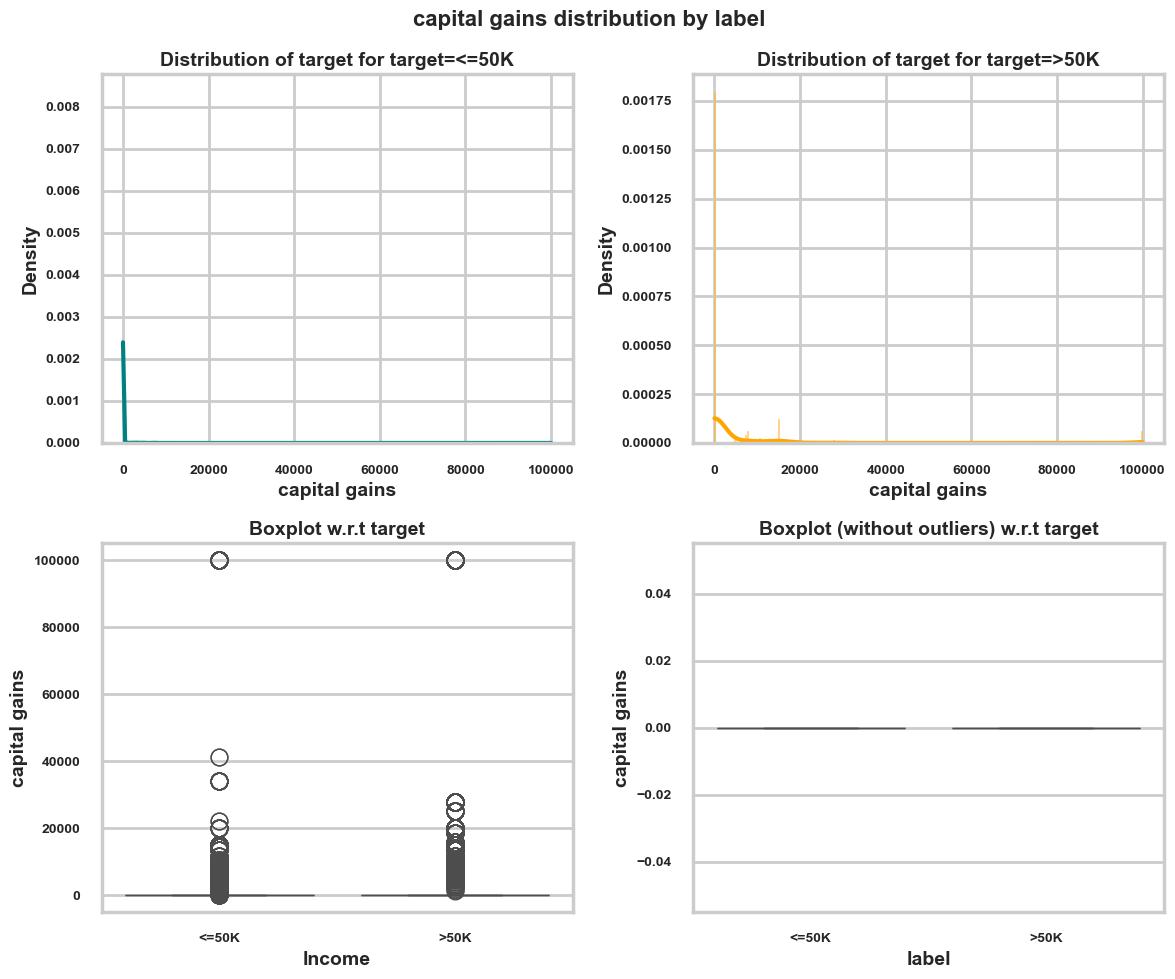

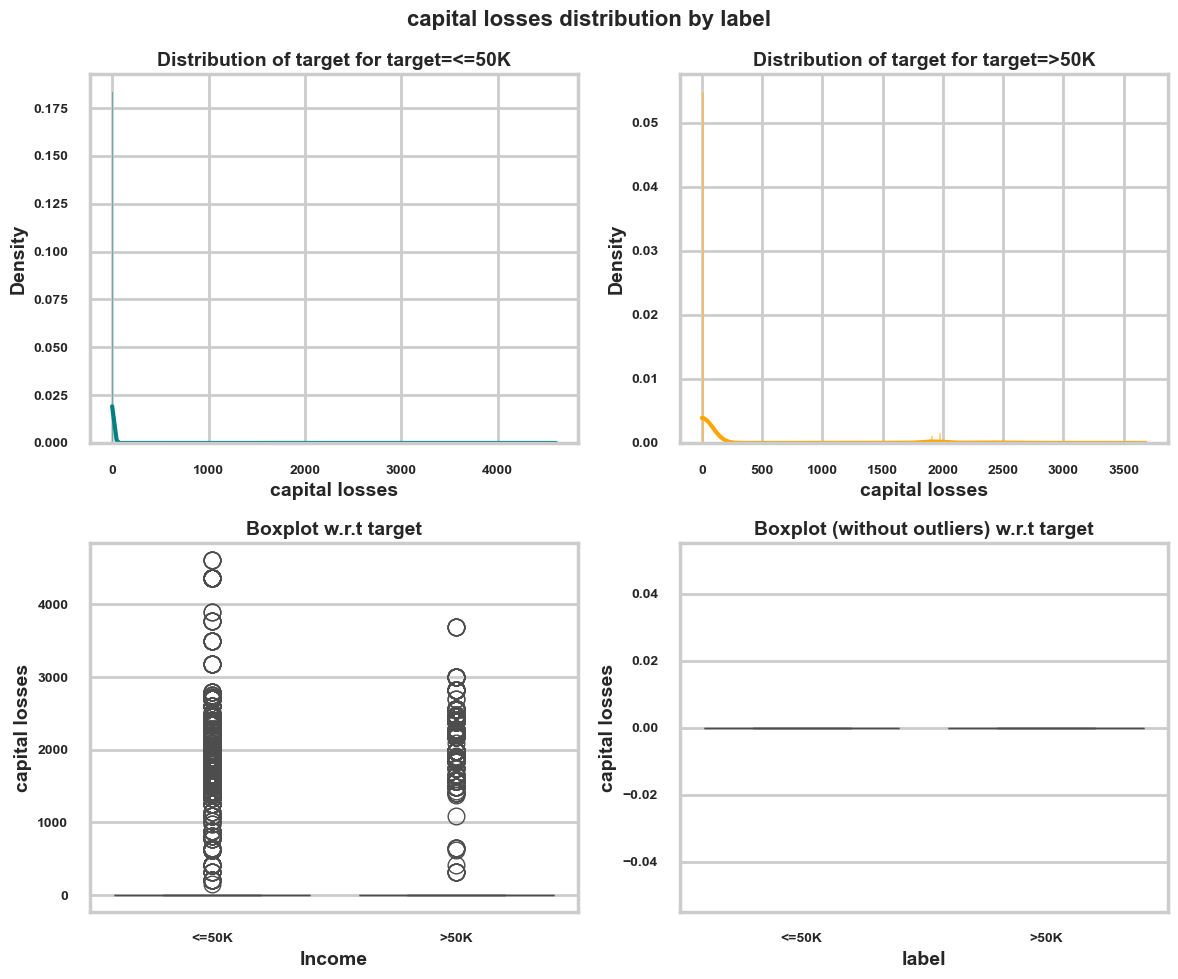

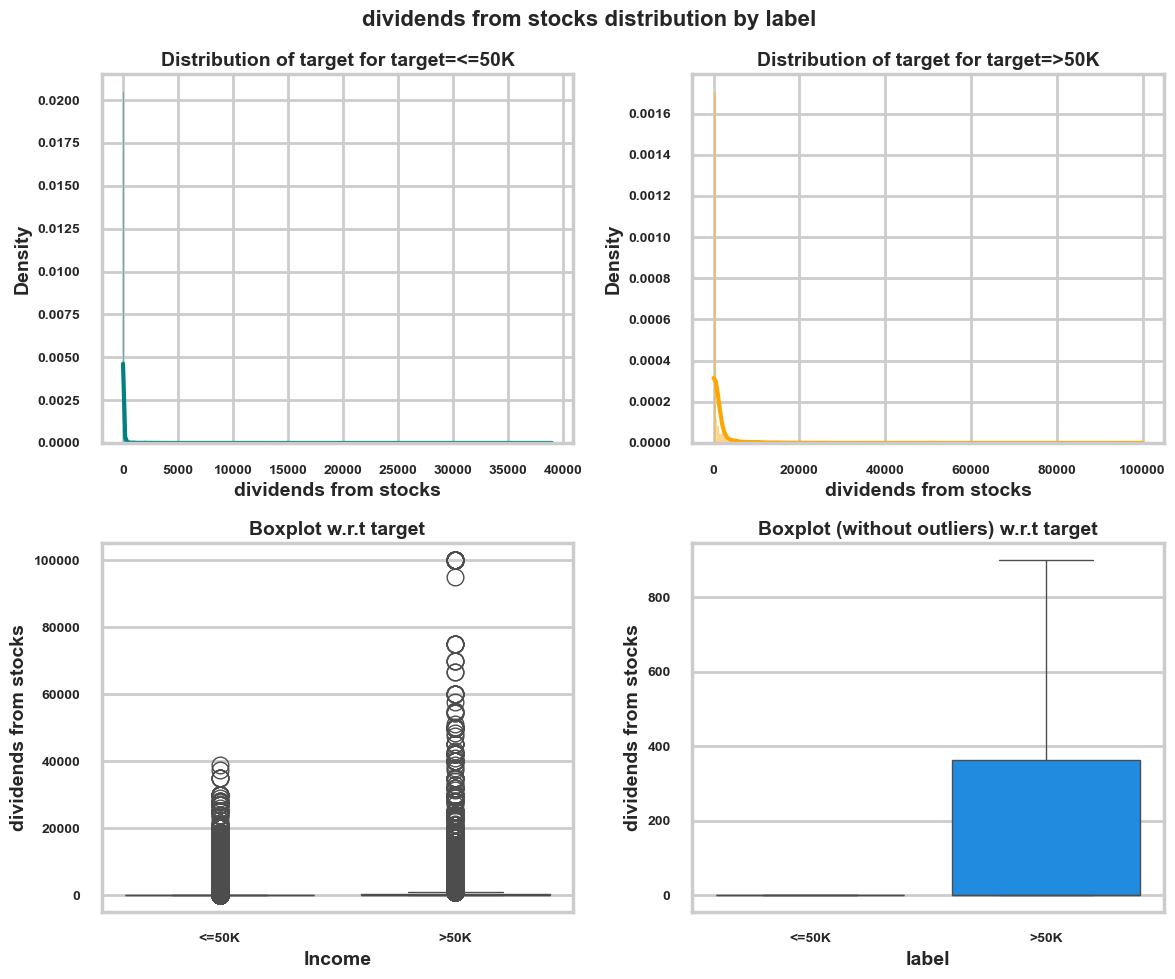

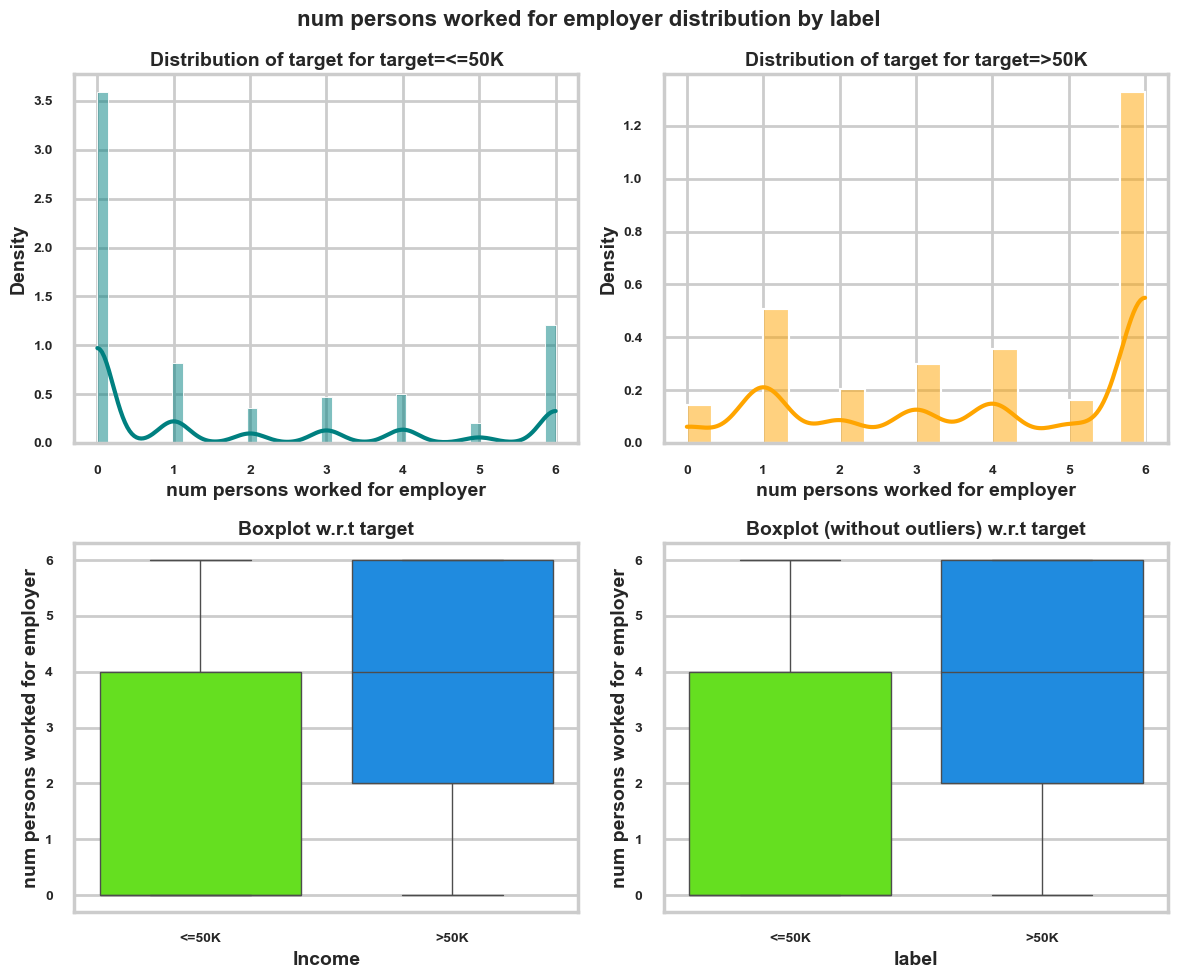

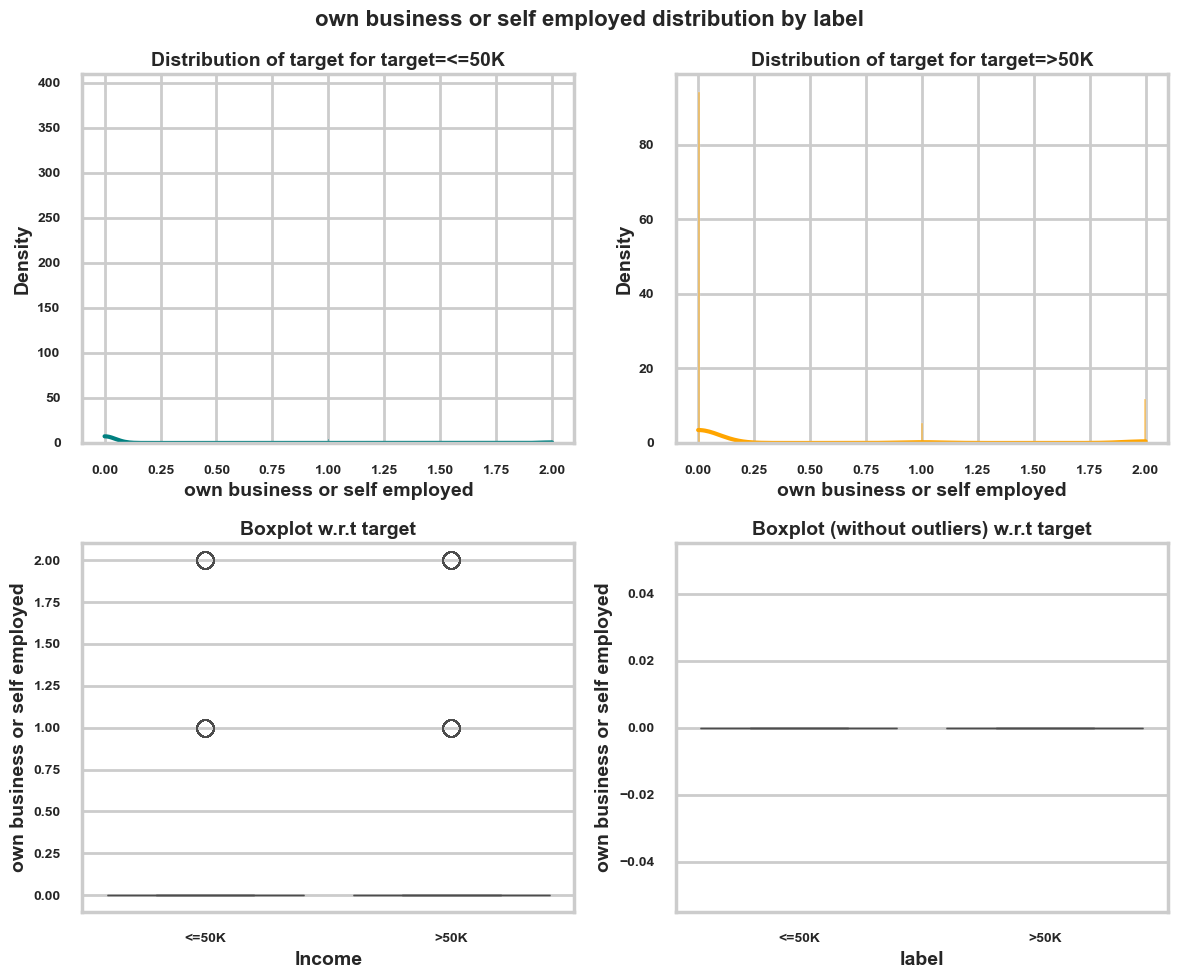

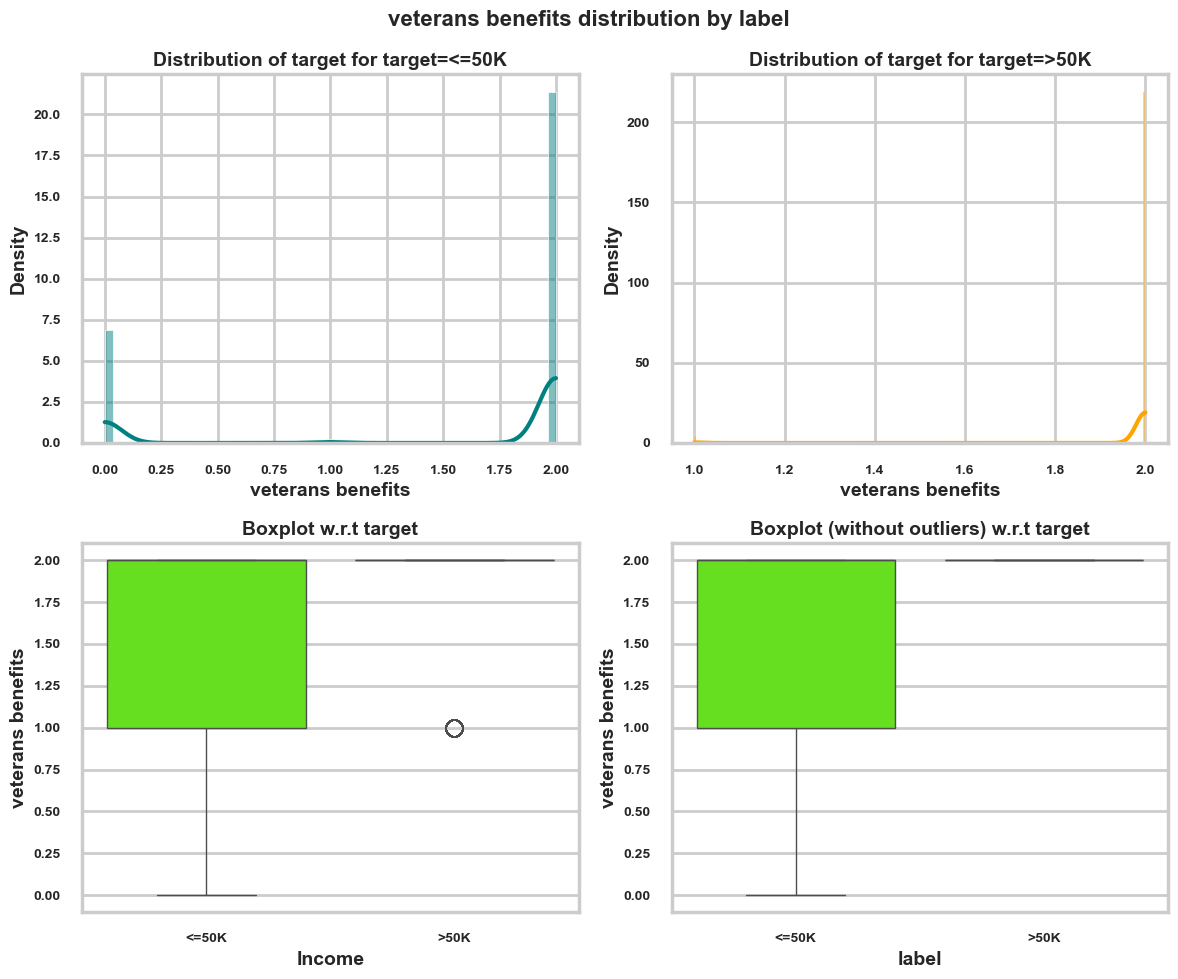

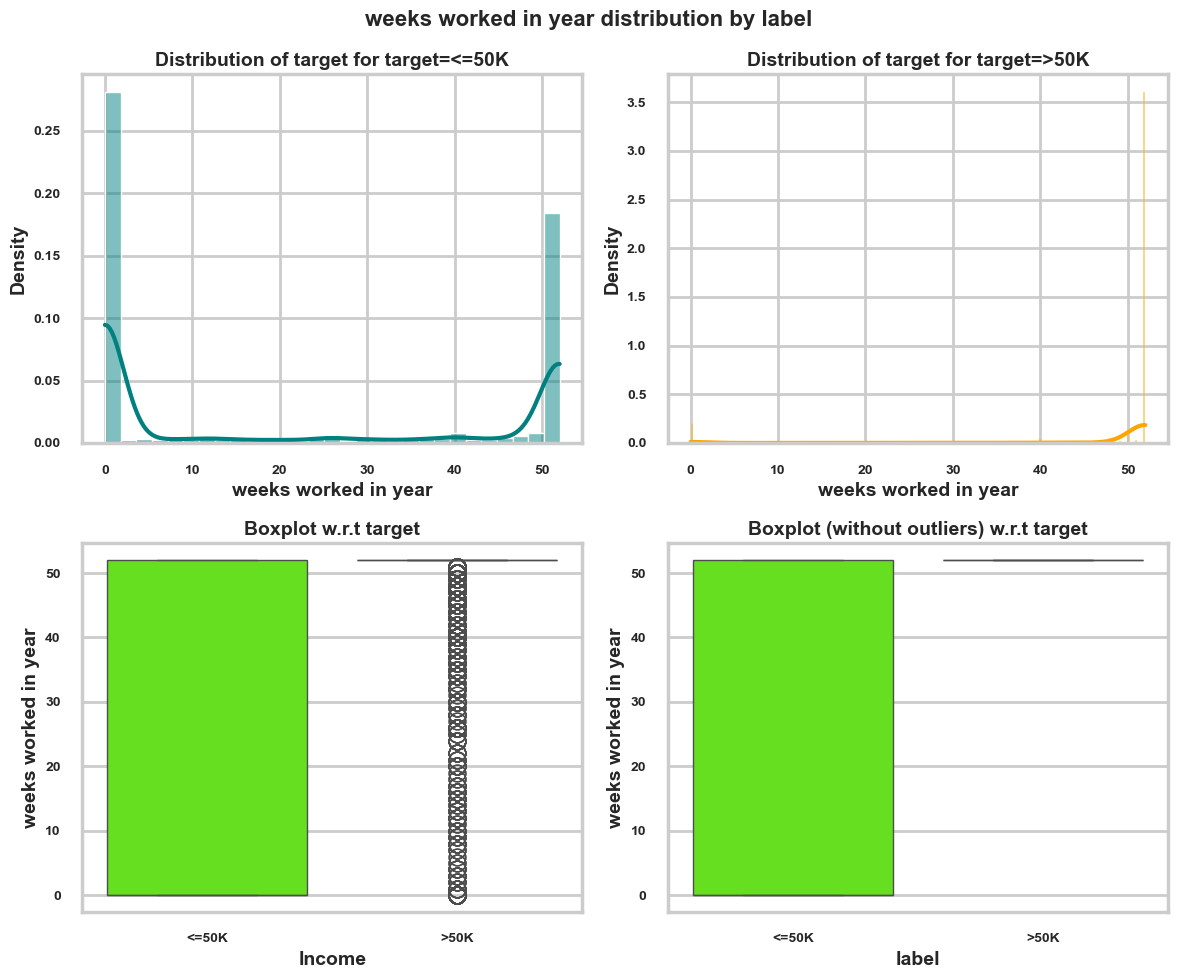

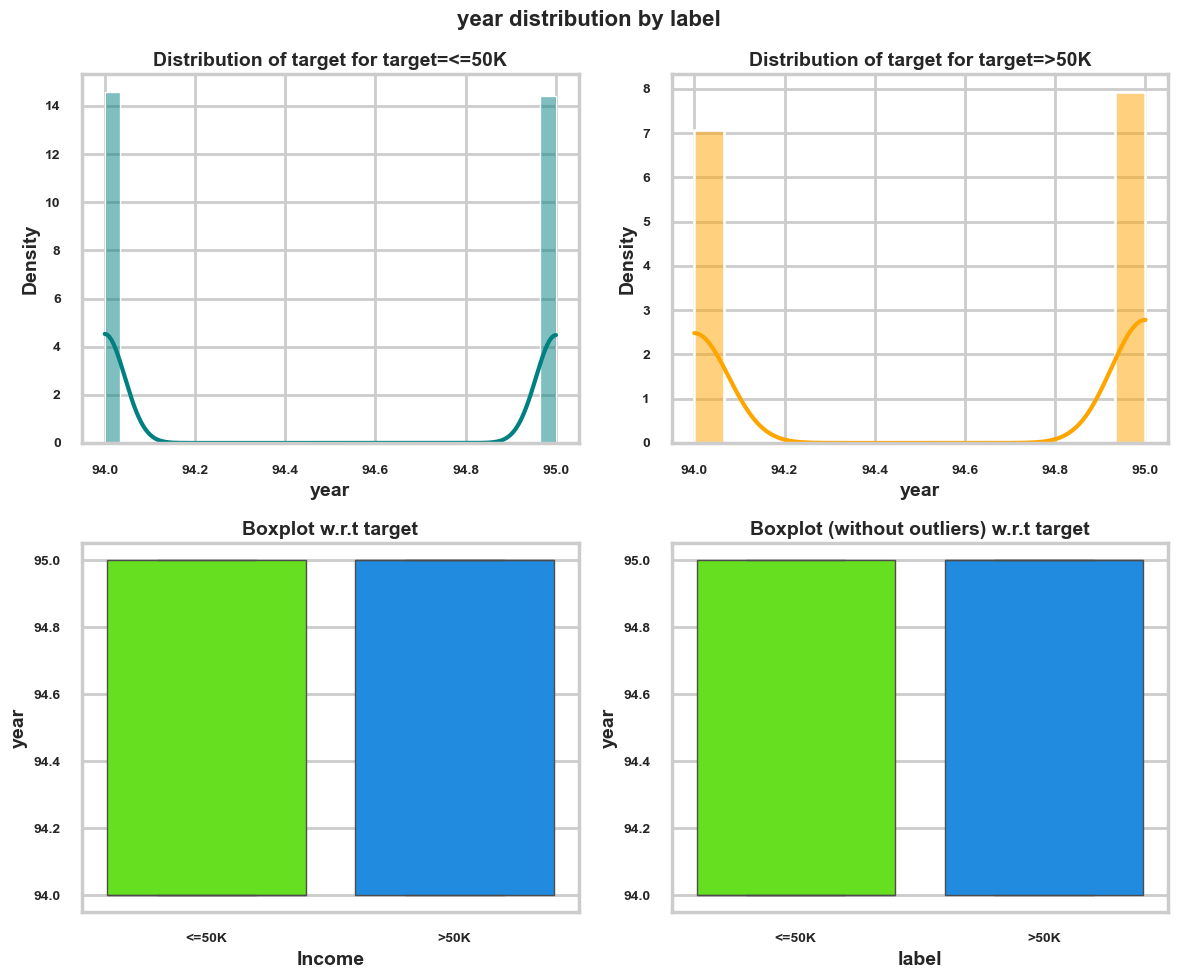

In [15]:
# Bivariate analysis: numeric vs target

# function to plot distributions wrt target
def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]), fontsize=14, fontweight='bold')
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]), fontsize=14, fontweight='bold')
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target", fontsize=14, fontweight='bold')
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")
    axs[1, 0].set_xlabel('Income', fontsize=14, fontweight='bold')


    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target", fontsize=14, fontweight='bold')
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )
    plt.suptitle(f'{predictor} distribution by {target}', fontsize=16, fontweight='bold')
    col_name = predictor.replace(' ', '_')
    axs[1, 0].set_xlabel('Income', fontsize=14, fontweight='bold')
    plt.savefig(f'{output_dirs[0]}/numeric_vs_target_{col_name}.png')

    plt.tight_layout()
    # plt.show()
    return fig

def stacked_barplot(data, predictor, target, figsize=(10, 6), num = 10):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    figsize: size of figure (default (10,6))
    palette: color palette for the bars (default 'Set2')
    num: number of top categories to display (default 10)
    """
    fig = plt.figure(figsize=figsize)
    count = data[predictor].nunique()
    col_name = predictor.replace(' ', '_')
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    fig=tab.plot(kind="bar", stacked=True, ax=fig.gca())
    plt.xlabel(predictor, fontsize=14, fontweight='bold')
    plt.ylabel('Income Proportion', fontsize=14, fontweight='bold')
    #plt.xticks(rotation=25)
    plt.title(f'Income proportion by {col_name}', fontsize=16, fontweight='bold')
    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.savefig(f'{output_dirs[0]}/cat_vs_target_{col_name}.png')
    return fig


target = 'label'
for i, col in enumerate(numeric_cols):
    #sns.boxplot(x='income', y=col, data=df, ax=axes[i])
    fig = distribution_plot_wrt_target(df, col, target)
    plt.show()
    plt.close()




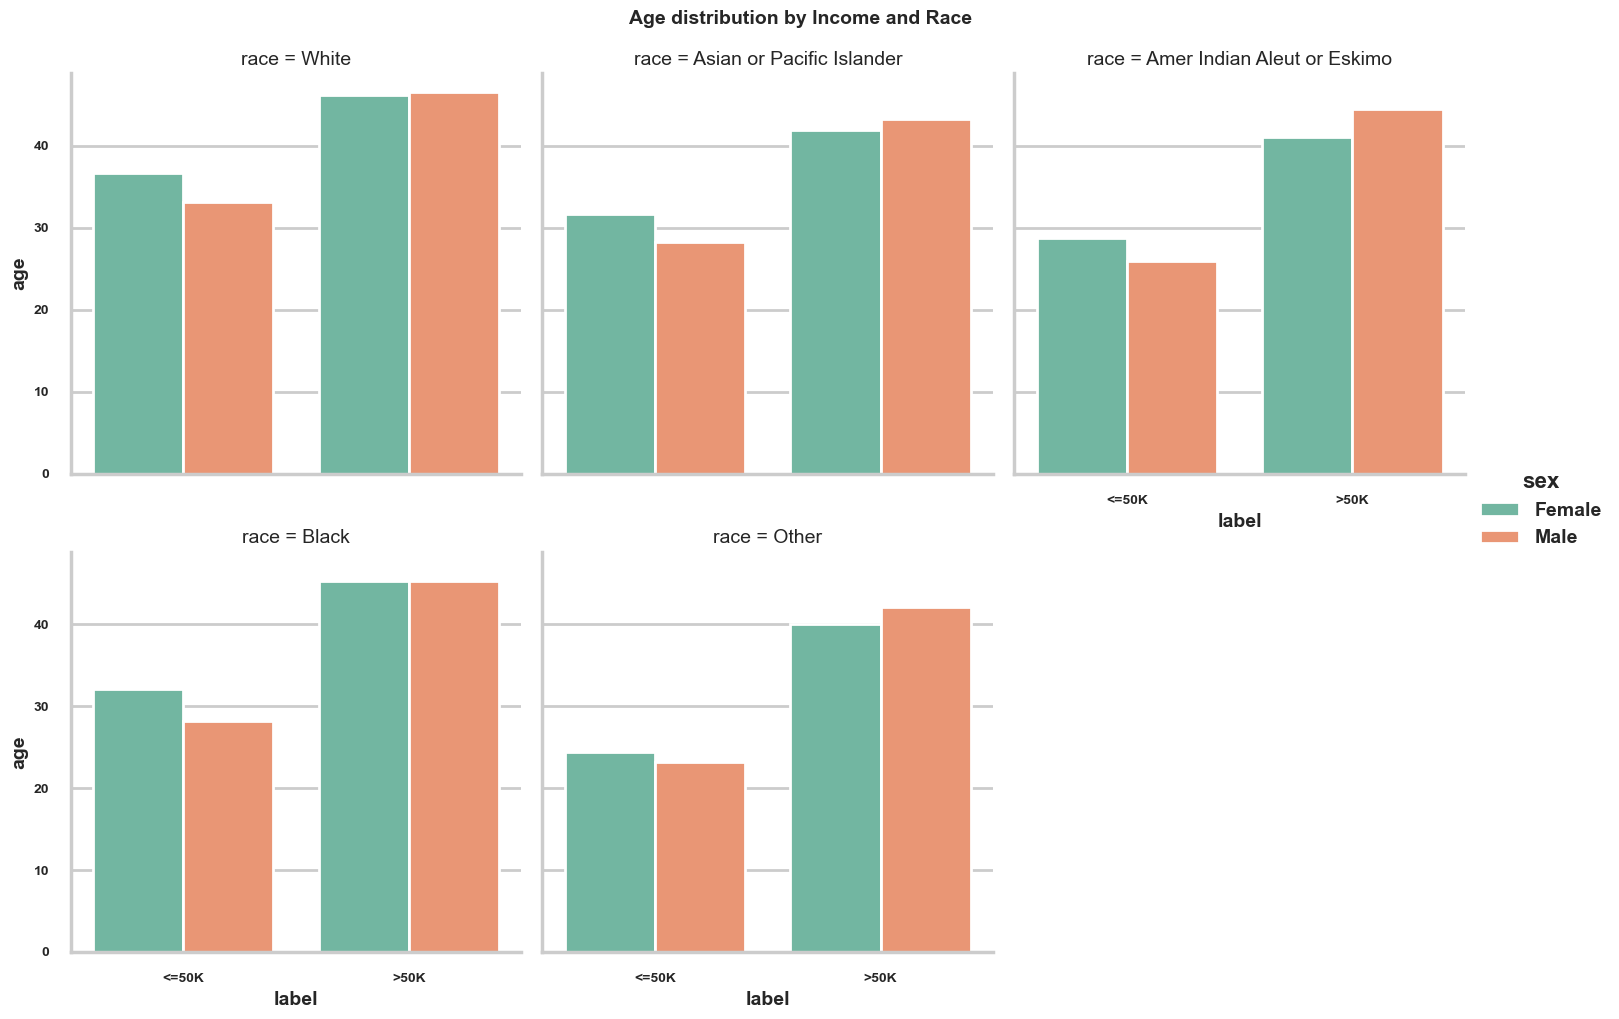

In [20]:
age_fig = sns.catplot(x='label', y='age', hue='sex', col='race', col_wrap=3, data=df, kind='bar', palette='Set2', errorbar=None)
age_fig.fig.suptitle('Age distribution by Income and Race', y=1.02, fontsize=14, fontweight='bold')
age_fig.savefig(f'{output_dirs[0]}/age_by_income_race.png')



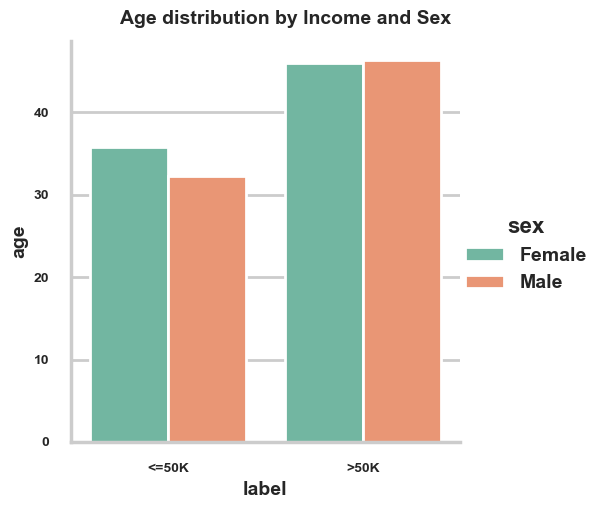

In [21]:
age_sex_fig = sns.catplot(x='label', y='age', hue='sex', data=df, kind='bar', palette='Set2', errorbar=None)
age_sex_fig.fig.suptitle('Age distribution by Income and Sex', y=1.02, fontsize=14, fontweight='bold')
age_sex_fig.savefig(f'{output_dirs[0]}/age_by_income_sex.png')



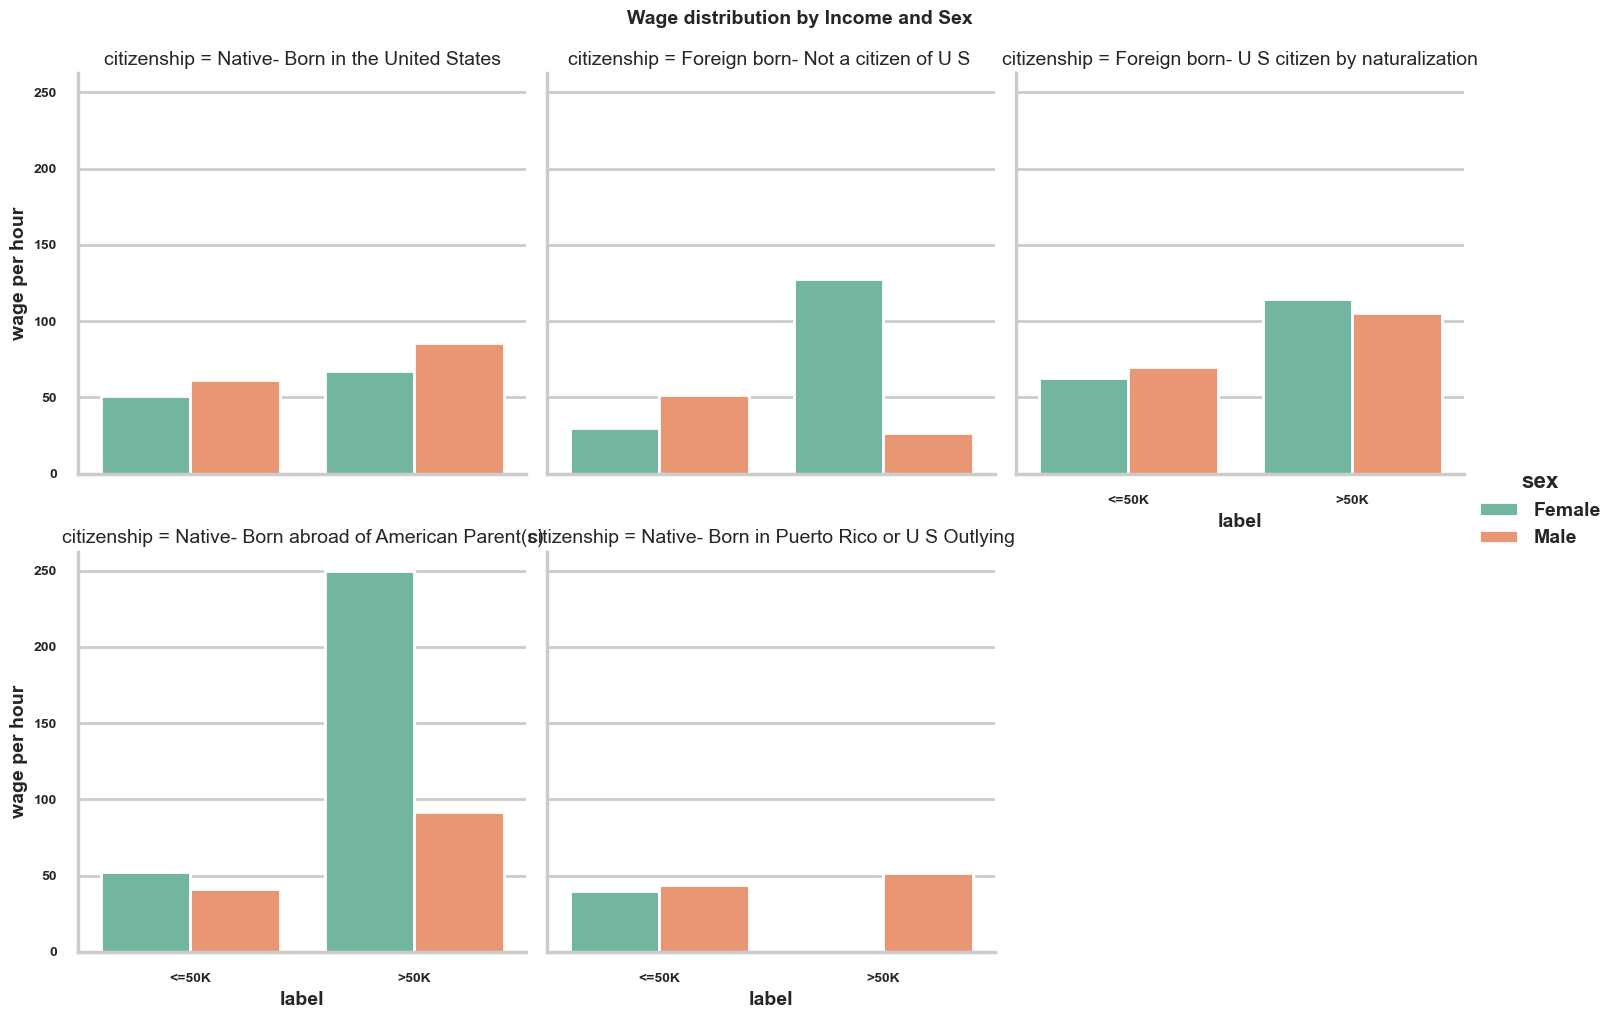

In [22]:
wage_fig = sns.catplot(x='label', y='wage per hour', col='citizenship', hue='sex', col_wrap=3, data=df, kind='bar', palette='Set2', errorbar=None)
wage_fig.fig.suptitle('Wage distribution by Income and Sex', y=1.02, fontsize=14, fontweight='bold')
wage_fig.savefig(f'{output_dirs[0]}/wage_by_income_sex.png')


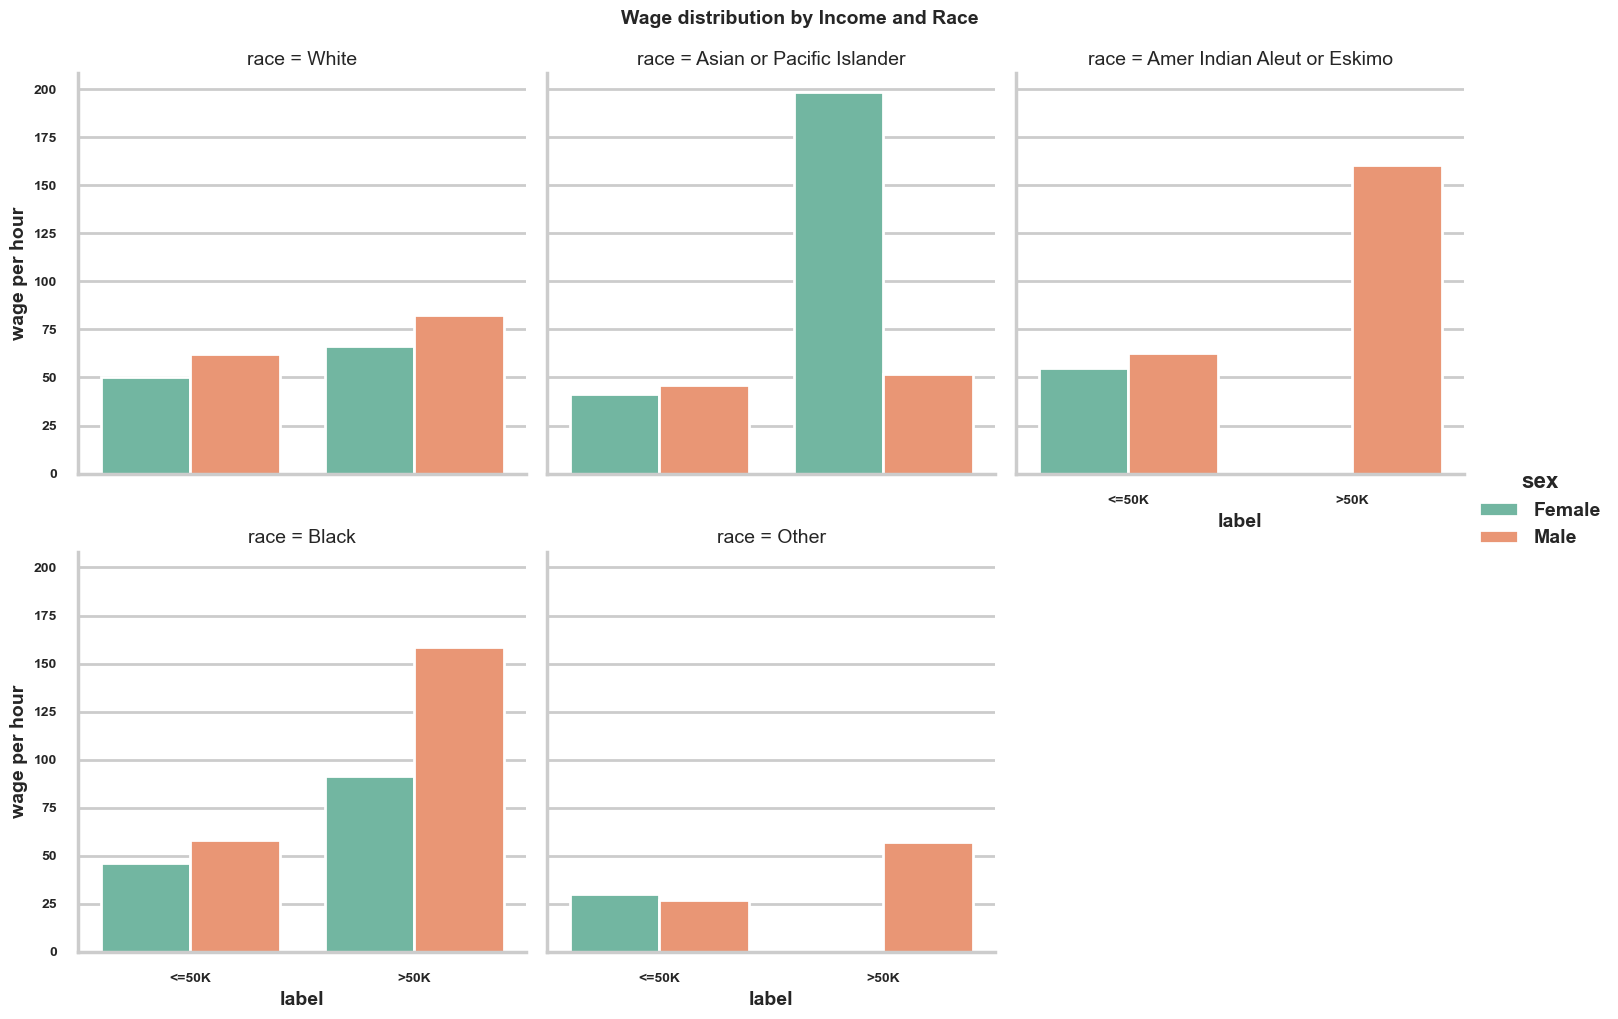

In [23]:
wage_race_fig = sns.catplot(x='label', y='wage per hour', hue='sex',col='race', data=df, col_wrap=3,kind='bar', palette='Set2', errorbar=None)
wage_race_fig.fig.suptitle('Wage distribution by Income and Race', y=1.02, fontsize=14, fontweight='bold')
wage_race_fig.savefig(f'{output_dirs[0]}/wage_by_income_race.png')


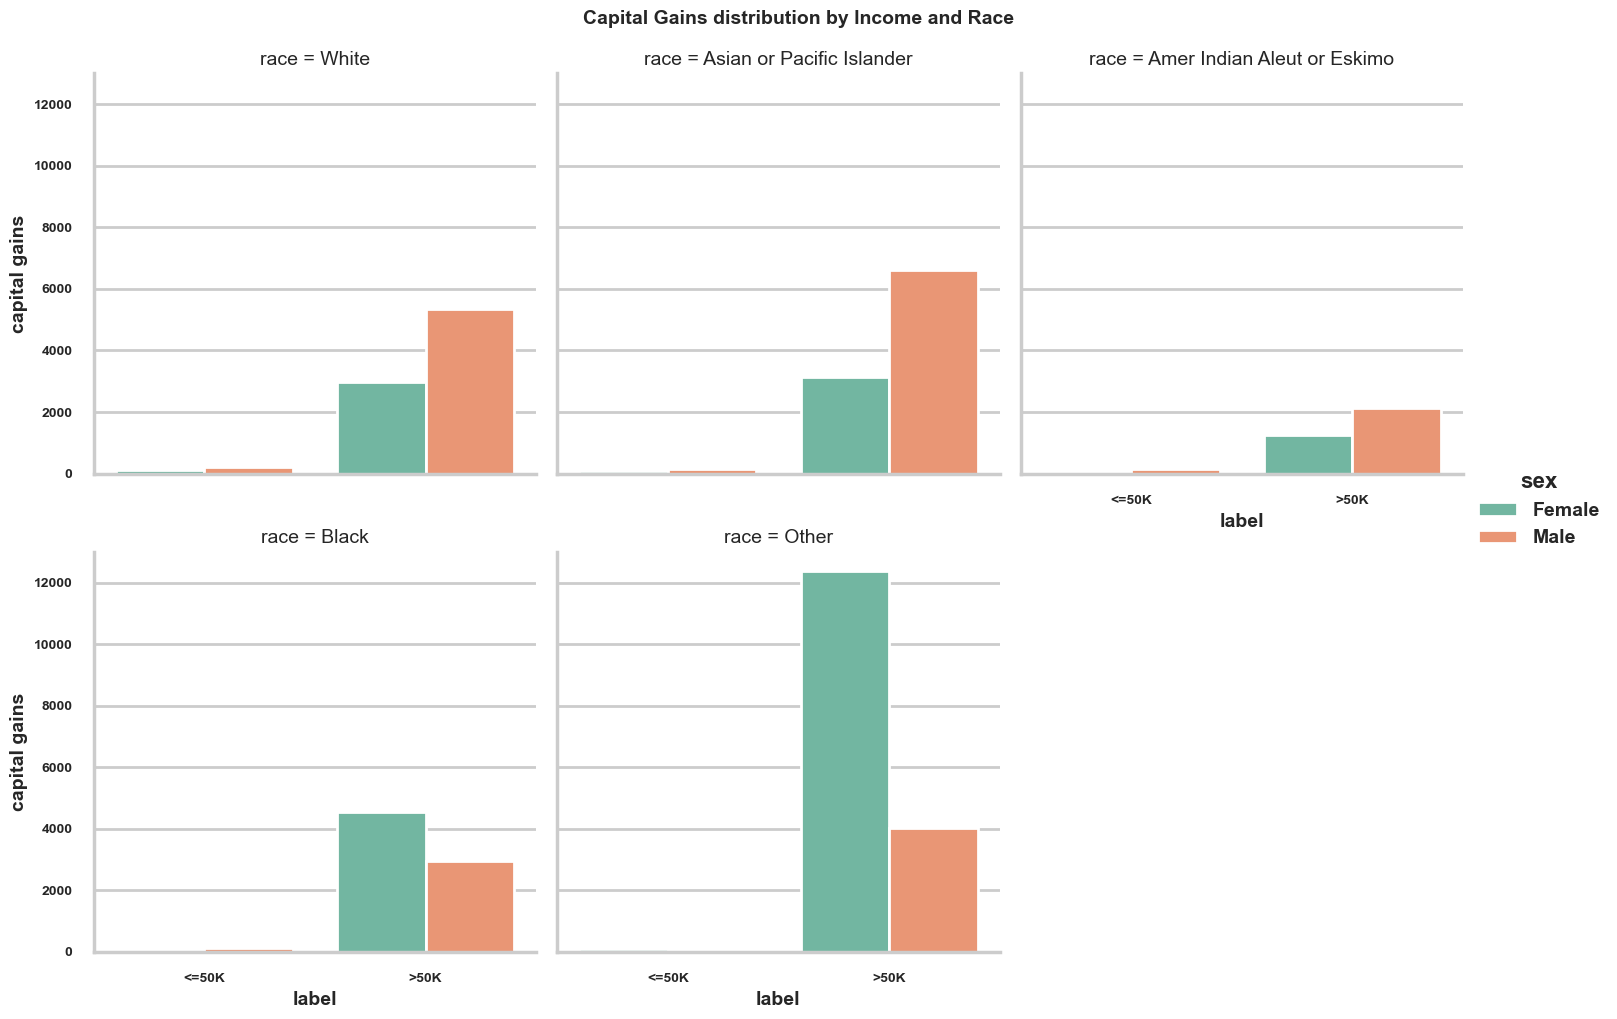

In [24]:
cap_gains_fig = sns.catplot(x='label', y='capital gains', hue='sex', data=df, kind='bar', col='race', col_wrap=3, palette='Set2', errorbar=None)
cap_gains_fig.fig.suptitle('Capital Gains distribution by Income and Race', y=1.02, fontsize=14, fontweight='bold')
cap_gains_fig.savefig(f'{output_dirs[0]}/capital_gains_by_income_race.png')



label                           <=50K   >50K    All
class of worker                                    
All                             87787  11478  99265
Private                         64699   7322  72021
Self-employed-incorporated       2130   1134   3264
Self-employed-not incorporated   7352   1090   8442
Local government                 6936    847   7783
Federal government               2328    597   2925
State government                 3742    485   4227
Never worked                      436      2    438
Without pay                       164      1    165
------------------------------------------------------------------------------------------------------------------------


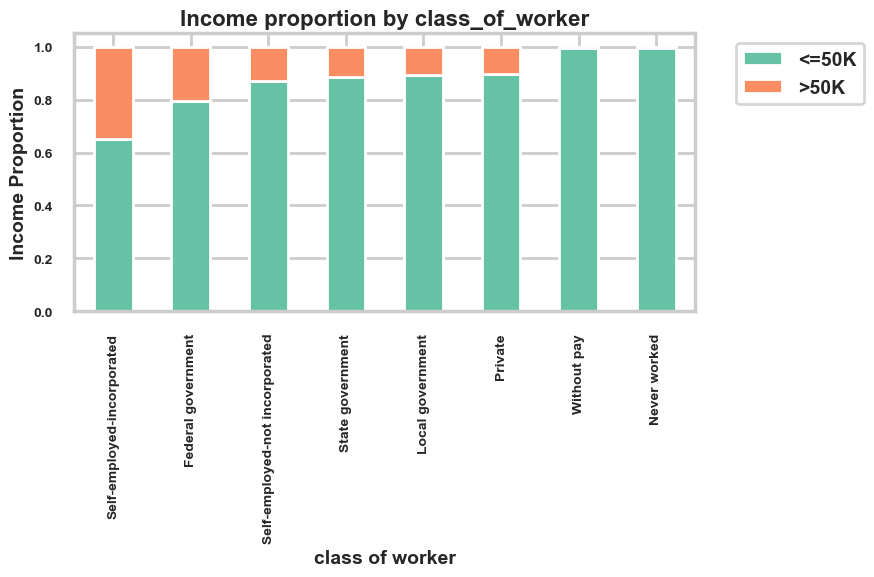

label                                    <=50K   >50K     All
education                                                    
All                                     183912  12382  196294
Bachelors degree(BA AB BS)               15944   3915   19859
Masters degree(MA MS MEng MEd MSW MBA)    4502   2038    6540
High school graduate                     46495   1879   48374
Some college but no degree               26022   1787   27809
Prof school degree (MD DDS DVM LLB JD)     824    969    1793
Doctorate degree(PhD EdD)                  606    657    1263
Associates degree-occup /vocational       4945    413    5358
Associates degree-academic program        3951    412    4363
7th and 8th grade                         7904     72    7976
11th grade                                6792     70    6862
10th grade                                7477     62    7539
9th grade                                 6155     38    6193
12th grade no diploma                     2091     34    2125
5th or 6

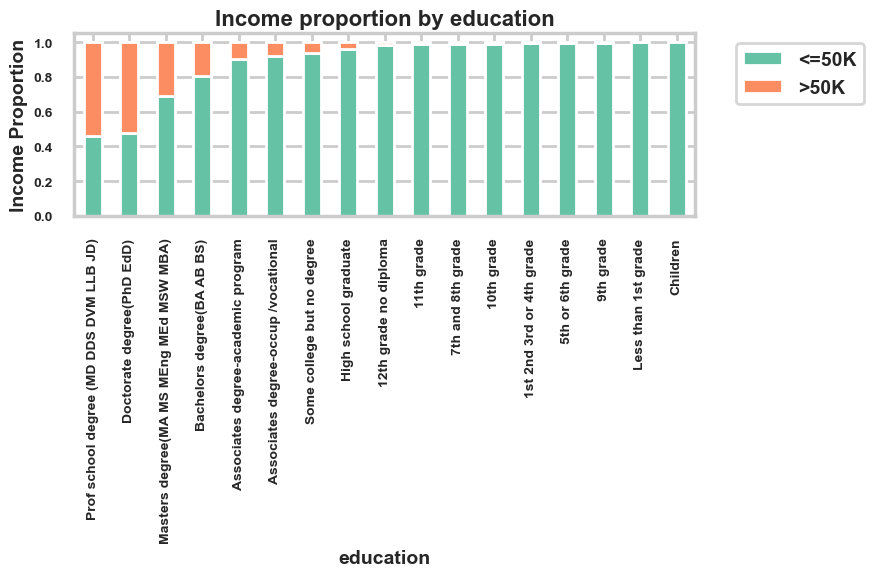

label                             <=50K   >50K     All
marital stat                                          
All                              183912  12382  196294
Married-civilian spouse present   74594   9600   84194
Never married                     82179   1117   83296
Divorced                          11641   1066   12707
Widowed                           10126    330   10456
Separated                          3301    158    3459
Married-spouse absent              1421     96    1517
Married-A F spouse present          650     15     665
------------------------------------------------------------------------------------------------------------------------


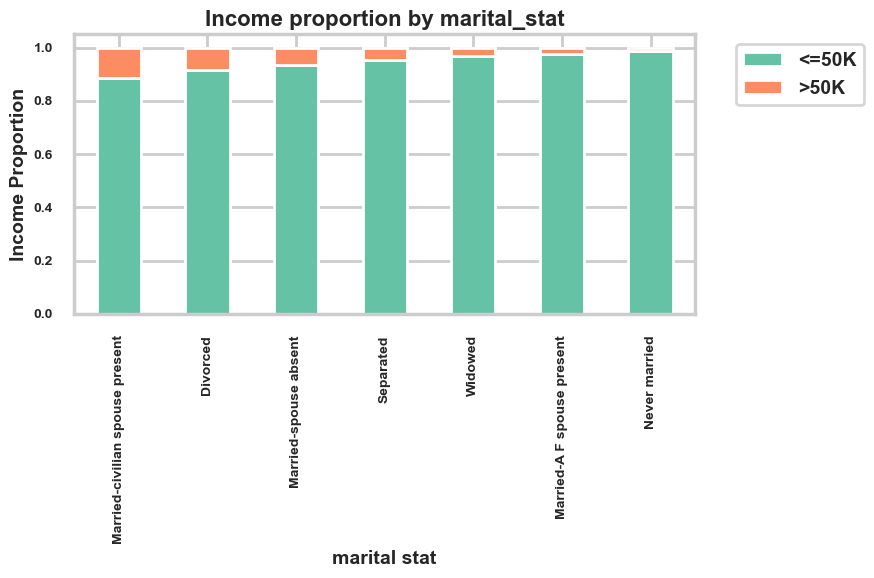

label                                <=50K   >50K    All
major industry code                                     
All                                  87351  11476  98827
Manufacturing-durable goods           7520   1494   9014
Finance insurance and real estate     5026   1119   6145
Other professional services           3438   1044   4482
Education                             7392    891   8283
Manufacturing-nondurable goods        6039    856   6895
Public administration                 3783    827   4610
Retail trade                         16280    789  17069
Business and repair services          5032    619   5651
Medical except hospital               4083    600   4683
Wholesale trade                       3042    552   3594
Construction                          5451    533   5984
Hospital services                     3479    485   3964
Transportation                        3733    476   4209
Communications                         911    270   1181
Utilities and sanitary services

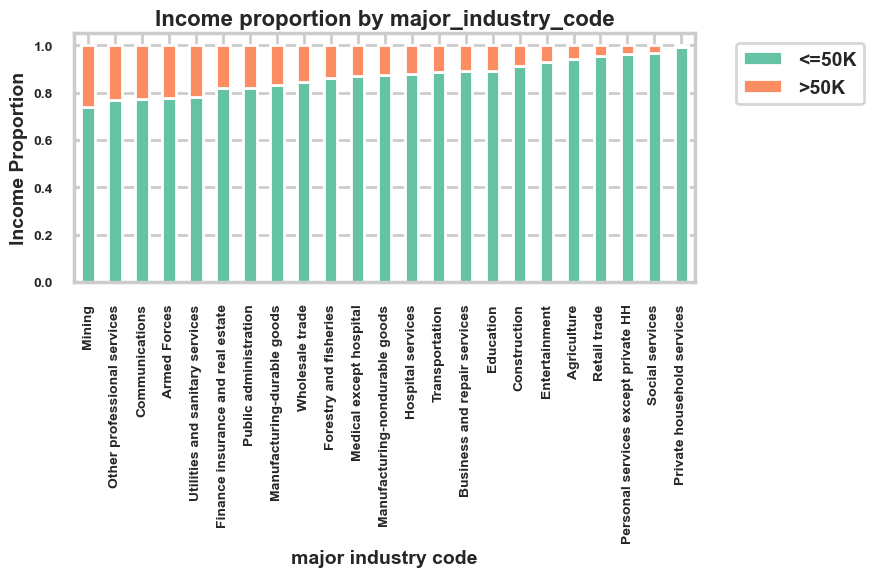

label                                  <=50K   >50K    All
major occupation code                                     
All                                    87351  11476  98827
Executive admin and managerial          8902   3593  12495
Professional specialty                 10465   3475  13940
Sales                                  10257   1524  11781
Precision production craft & repair     9562    955  10517
Adm support including clerical         14390    446  14836
Technicians and related support         2657    361   3018
Protective services                     1402    259   1661
Transportation and material moving      3761    259   4020
Machine operators assmblrs & inspctrs   6142    235   6377
Farming forestry and fishing            2983    160   3143
Other service                          11977    120  12097
Handlers equip cleaners etc             4047     79   4126
Armed Forces                              28      8     36
Private household services               778      2    7

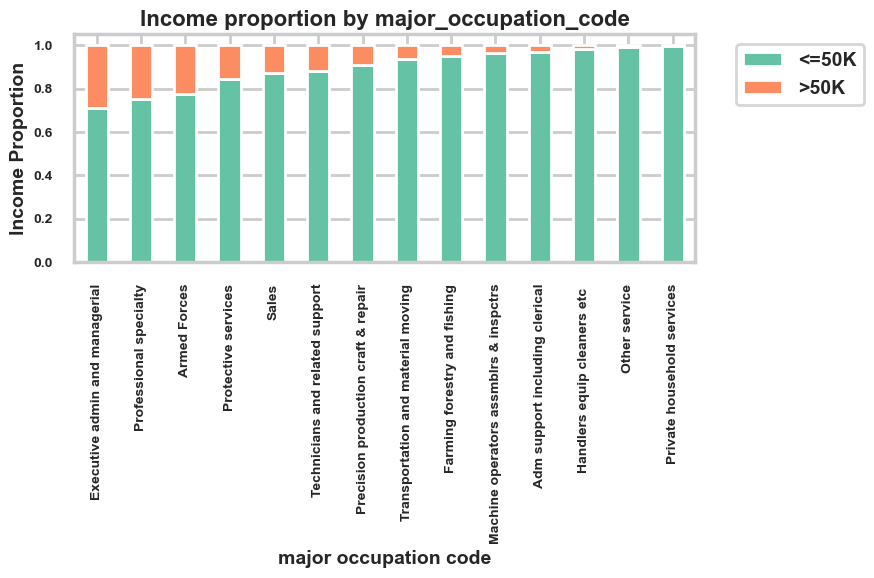

label                         <=50K   >50K     All
race                                              
All                          183912  12382  196294
White                        153108  11272  164380
Black                         19666    540   20206
Asian or Pacific Islander      5391    430    5821
Other                          3554     91    3645
Amer Indian Aleut or Eskimo    2193     49    2242
------------------------------------------------------------------------------------------------------------------------


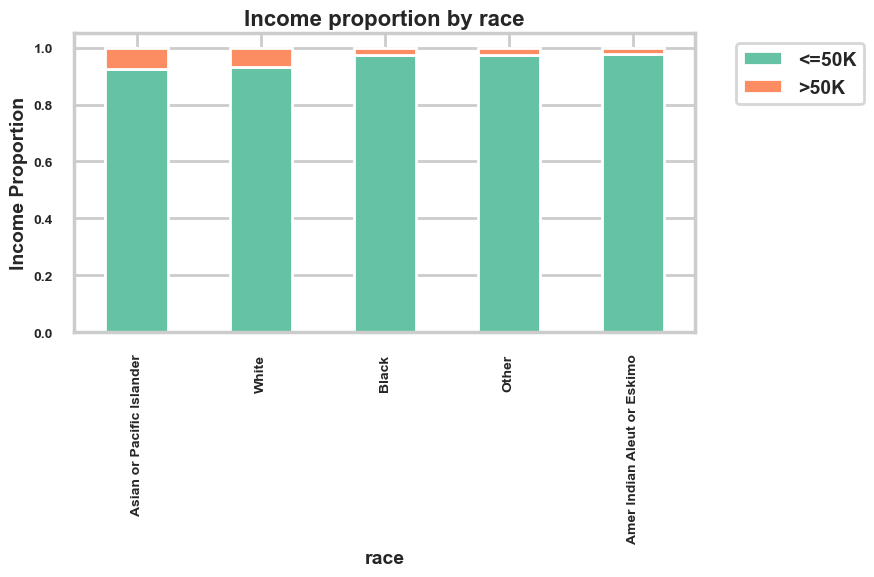

label                       <=50K   >50K     All
hispanic origin                                 
All                        183099  12325  195424
All other                  157036  11767  168803
Mexican-American             7836    172    8008
Mexican (Mexicano)           7128     82    7210
Other Spanish                2395     81    2476
Central or South American    3811     80    3891
Puerto Rican                 3238     68    3306
Cuban                        1061     61    1122
Do not know                   297      8     305
Chicano                       297      6     303
------------------------------------------------------------------------------------------------------------------------


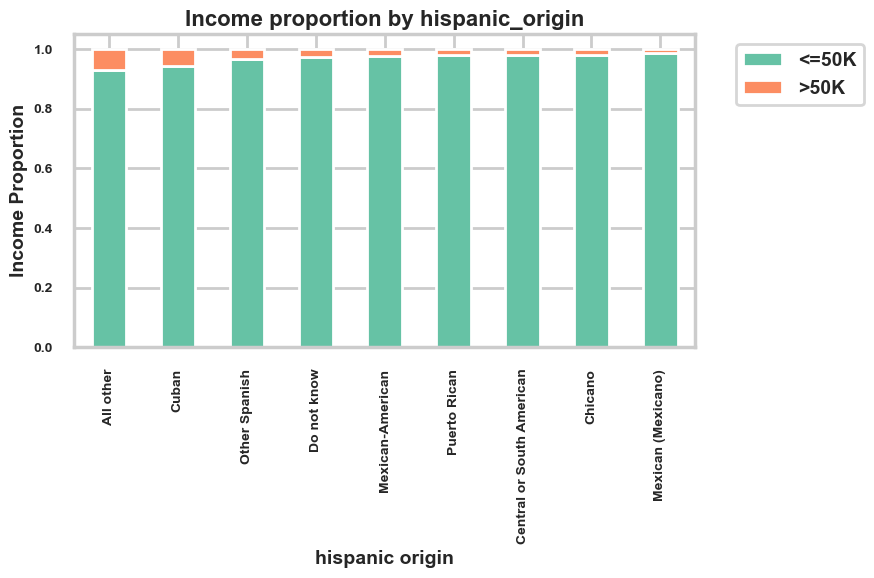

label    <=50K   >50K     All
sex                          
All     183912  12382  196294
Male     84175   9719   93894
Female   99737   2663  102400
------------------------------------------------------------------------------------------------------------------------


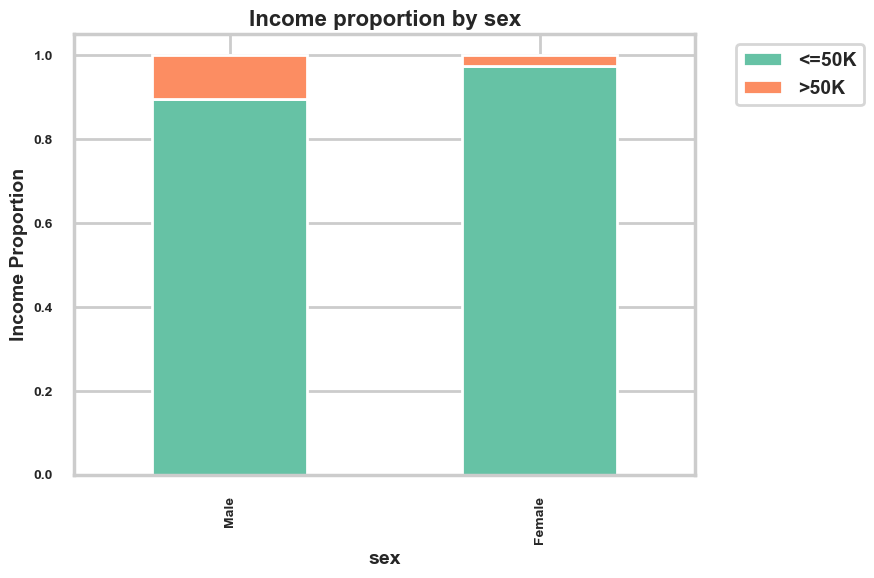

label                                <=50K   >50K     All
full or part time employment stat                        
All                                 183912  12382  196294
Children or Armed Forces            114758   5874  120632
Full-time schedules                  35362   5366   40728
Not in labor force                   26264    462   26726
PT for non-econ reasons usually FT    2929    393    3322
PT for econ reasons usually PT        1054    155    1209
Unemployed full-time                  2227     83    2310
PT for econ reasons usually FT         494     31     525
Unemployed part- time                  824     18     842
------------------------------------------------------------------------------------------------------------------------


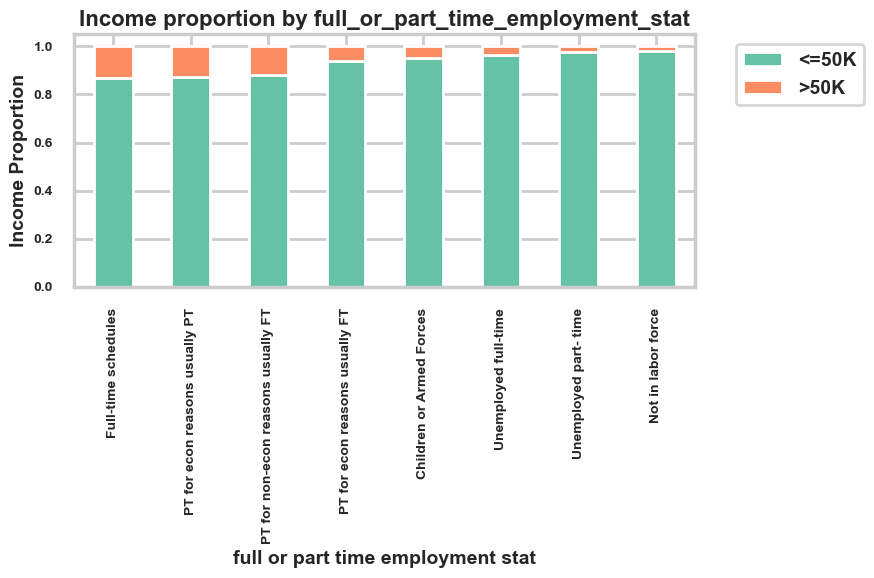

label                          <=50K   >50K     All
tax filer stat                                     
All                           183912  12382  196294
Joint both under 65            58514   8853   67367
Single                         35114   2295   37409
Joint both 65+                  7876    450    8326
Head of household               6977    448    7425
Joint one under 65 & one 65+    3563    301    3864
Nonfiler                       71868     35   71903
------------------------------------------------------------------------------------------------------------------------


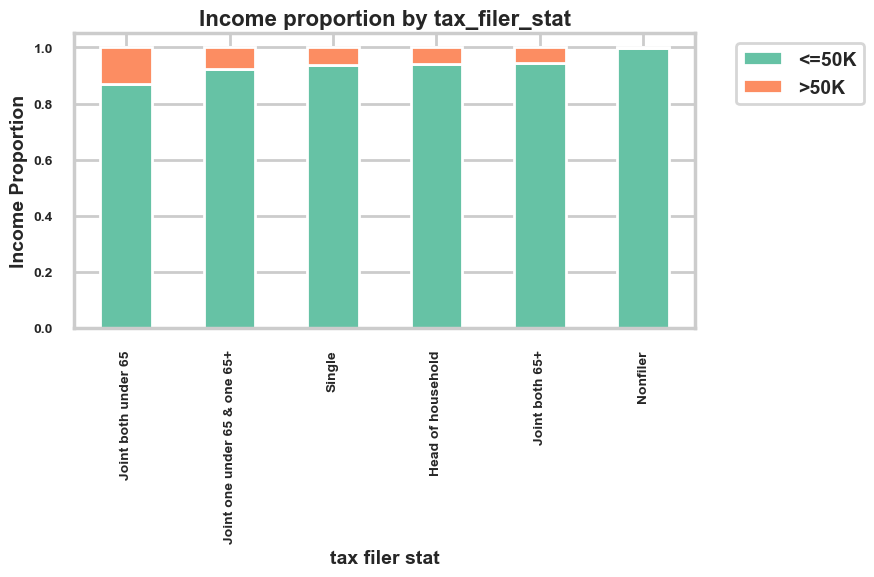

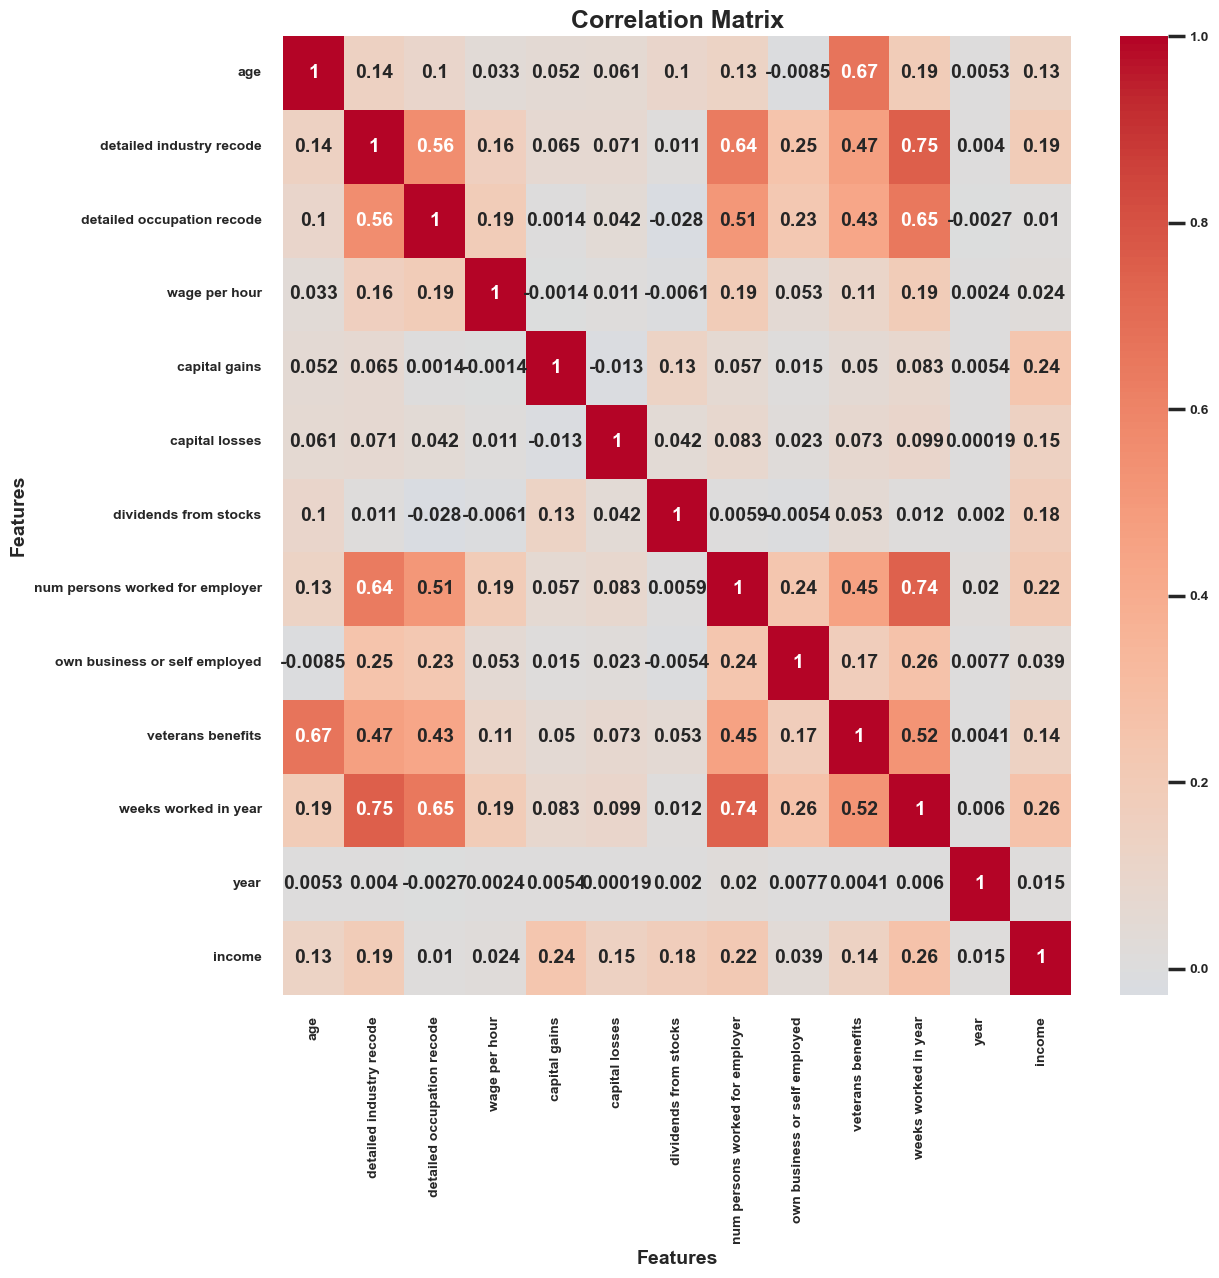

EDA completed. Plots saved in 'plots_classification_outputs/'.


In [25]:
# Bivariate: categorical vs target (stacked bar)
for col in categorical_cols[:10]:
    #fig = plt.figure(figsize=(10, 6))
    fig=stacked_barplot(df, col, 'label', figsize=(9,6), num=10)
    plt.show()
    plt.close()

# Correlation matrix
ncorr = len(numeric_cols) + 1  # +1 for the target variable 'income'
corr = df[numeric_cols + ['income']].corr()
plt.figure(figsize=(ncorr,ncorr))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix', fontsize=18, fontweight='bold')
plt.xlabel('Features', fontsize=14, fontweight='bold')
plt.ylabel('Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{output_dirs[0]}/correlation_matrix.png')
plt.show()
plt.close()


print(f"EDA completed. Plots saved in '{output_dirs[0]}/'.")


### Preprocessing

In [26]:


# =============================================================================
# Preprocessing
# =============================================================================
X = df.drop(['label', 'income', 'weight'], axis=1, errors='ignore')
y = df['income']

# Update column lists after potential drops
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing pipelines
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# =============================================================================
# Split Dataset into Train/Test Split
# =============================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"\nTrain size: {X_train.shape}, Test size: {X_test.shape}")



Train size: (137405, 32), Test size: (58889, 32)


### Model Training and Hyperparameter Tuning

In [27]:
# =============================================================================
# Model Training & Hyperparameter Tuning
# =============================================================================
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    print(f"\n{name} Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC-AUC: {auc:.4f}")
    return {'name': name, 'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'auc': auc}

# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title("Confusion Matrix with Percentages")
    plt.tight_layout()
    # plt.show()
    return cm

# Models to compare
models = []
results = []

# Logistic Regression
lr_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])
param_lr = {'classifier__C': [0.01, 0.1, 1, 10]}
grid_lr = GridSearchCV(lr_pipeline, param_lr, cv=5, scoring='roc_auc', n_jobs=-1)
grid_lr.fit(X_train, y_train)
models.append(('Logistic Regression', grid_lr.best_estimator_))
res = evaluate_model(grid_lr.best_estimator_, X_test, y_test, 'Logistic Regression')
results.append(res)

# Random Forest
rf_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])
param_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(rf_pipeline, param_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train, y_train)
models.append(('Random Forest', grid_rf.best_estimator_))
res = evaluate_model(grid_rf.best_estimator_, X_test, y_test, 'Random Forest')
results.append(res)

# XGBoost
xgb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False))
])
param_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0]
}
grid_xgb = GridSearchCV(xgb_pipeline, param_xgb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_xgb.fit(X_train, y_train)
models.append(('XGBoost', grid_xgb.best_estimator_))
res = evaluate_model(grid_xgb.best_estimator_, X_test, y_test, 'XGBoost')
results.append(res)

# Save results table
results_df = pd.DataFrame(results)
results_df.to_csv(f'{output_dirs[0]}/model_comparison.csv', index=False)
print(f"\nModel comparison saved to '{output_dirs[0]}/model_comparison.csv'")



Logistic Regression Results:
Accuracy: 0.8484
Precision: 0.2807
Recall: 0.8977
F1-score: 0.4276
ROC-AUC: 0.9446

Random Forest Results:
Accuracy: 0.9491
Precision: 0.6086
Recall: 0.5402
F1-score: 0.5724
ROC-AUC: 0.9425

XGBoost Results:
Accuracy: 0.9509
Precision: 0.6224
Recall: 0.5647
F1-score: 0.5922
ROC-AUC: 0.9482

Model comparison saved to 'plots_classification_outputs/model_comparison.csv'


#### Confusion Matrix of all Models

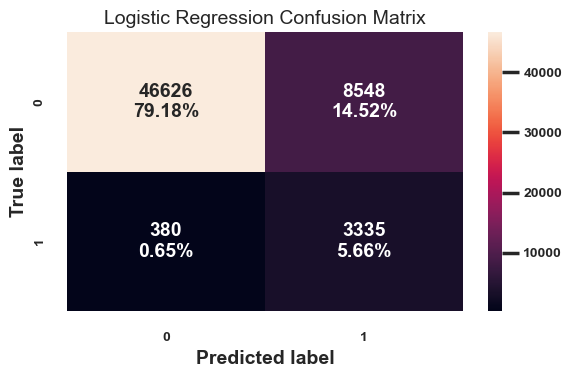

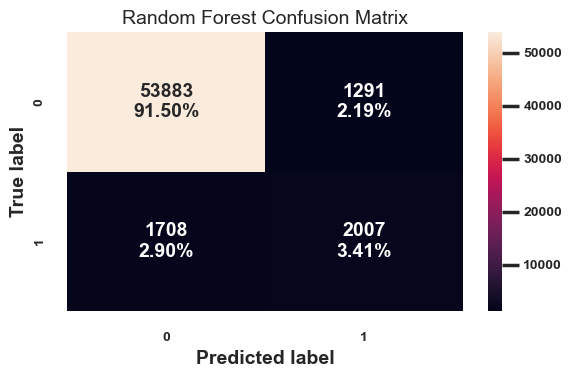

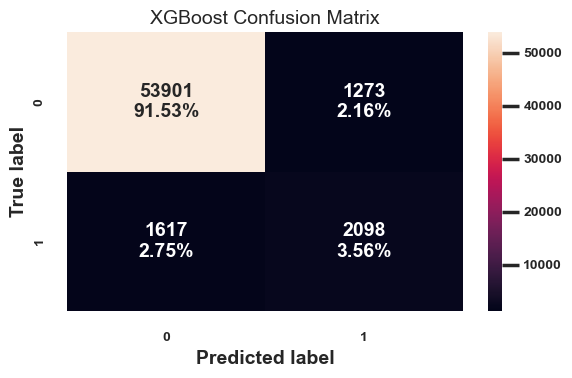

In [28]:
# =============================================================================
# Confusion matrices for all models
# ==============================================================================
for name, model in models:
    cm = confusion_matrix_sklearn(model, X_test, y_test)
    plt.title(f'{name} Confusion Matrix')
    plt.savefig(f'{output_dirs[0]}/{name.lower().replace(" ", "_")}_confusion_matrix.png')
    plt.show()
    plt.close()



### ROC-AUC curves of the models

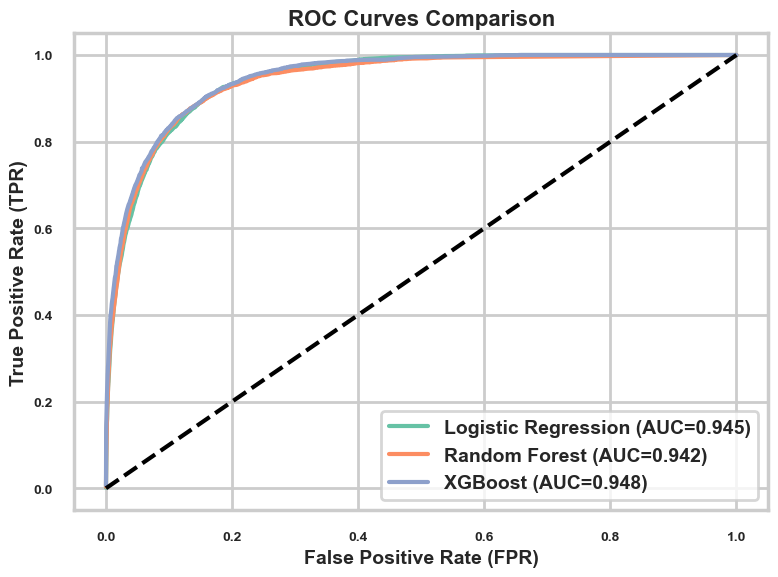

In [29]:
# =============================================================================
# ROC Curves of the Models
# =============================================================================
best_model_dict = {}
plt.figure(figsize=(8,6))
for name, model in models:
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    best_auc = best_model_dict.get('AUC', auc )
    if auc >= best_auc:
        best_model_dict['AUC'] = auc
        best_model_dict['model'] = model
        best_model_dict['name'] = name
    sns.lineplot(x=fpr, y=tpr, label=f'{name} (AUC={auc:.3f})')
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('False Positive Rate (FPR)', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate (TPR)', fontsize=14, fontweight='bold')
plt.title('ROC Curves Comparison', fontsize=16, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig(f'{output_dirs[0]}/roc_curves.png')
plt.show()
plt.close()


### Feature of Importance of the Best Model


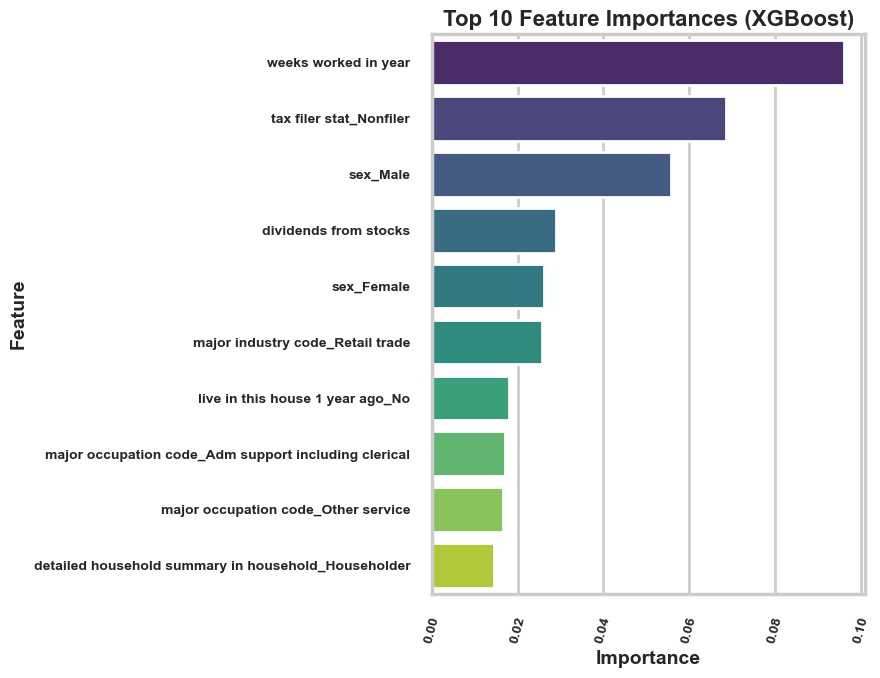

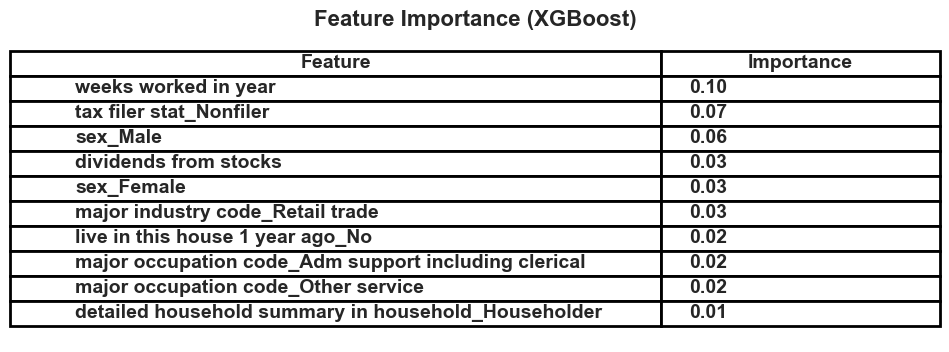

In [30]:
# =============================================================================
# Feature Importance (XGBoost) – seaborn barplot
# =============================================================================

best_model = best_model_dict['model']
preprocessor_fitted = best_model.named_steps['preprocessor']
cat_feature_names = preprocessor_fitted.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numeric_cols, cat_feature_names])
importances = best_model.named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=all_feature_names).sort_values(ascending=False).head(10)

plt.figure(figsize=(9,7))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
plt.xlabel('Importance', fontsize=14, fontweight='bold')
plt.ylabel('Feature', fontsize=14, fontweight='bold')
plt.title('Top 10 Feature Importances (XGBoost)', fontsize=16, fontweight='bold')
plt.xticks(rotation=75)
plt.tight_layout()
plt.savefig(f'{output_dirs[0]}/feature_importance_top10.png')
plt.show()
plt.close()

# =============================================================================
# Feature Importance Table (as image) – using matplotlib table
# =============================================================================
def save_feature_importance_table(feat_imp_series, filename):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.axis('off')
    ax.axis('tight')
    data = feat_imp_series.reset_index()
    data.columns = ['Feature', 'Importance']
    data['Importance'] = data['Importance']
    cell_text = [[f"{x:.2f}" if isinstance(x, float) else x for x in row] for row in data.values]
    col_widths = [0.7, 0.3]
    table = ax.table(cellText=cell_text, colLabels=data.columns, colWidths=col_widths, loc='center', cellLoc='left')
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1.5, 1.5)
    plt.title('Feature Importance (XGBoost)', fontsize=16, fontweight='bold')
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    plt.show()
    plt.close()

save_feature_importance_table(feat_imp.head(10), f'{output_dirs[0]}/feature_importance_table.png')


### Model Architecture

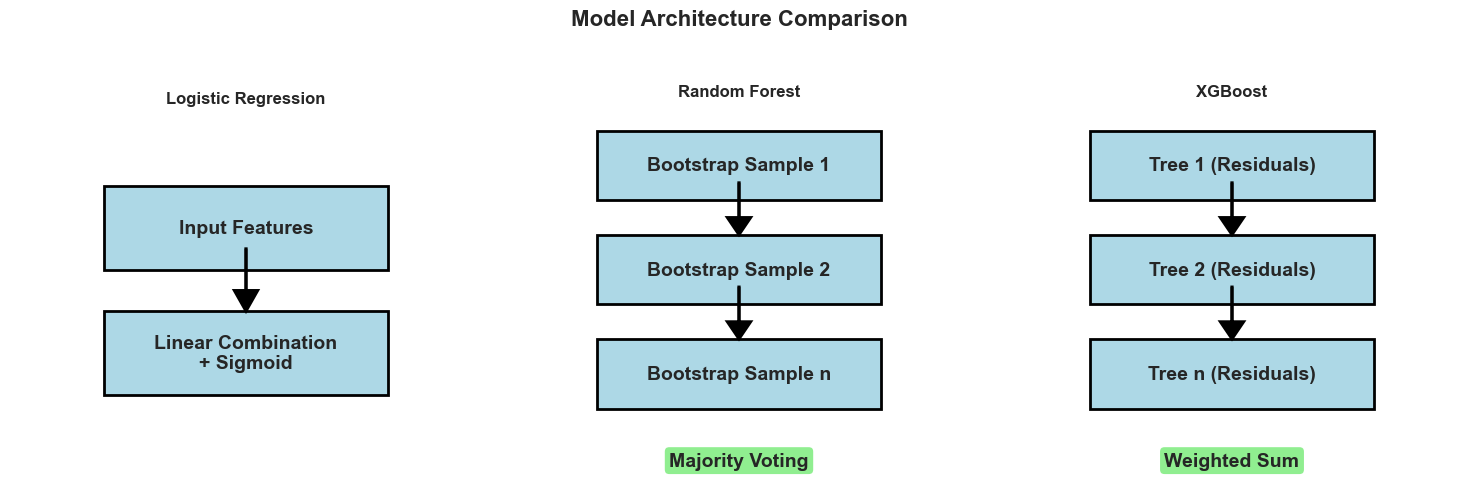


Classification completed. All plots saved in 'plots_classification_outputs/'.
Best model saved to 'models_classification_outputs/best_classifier.pkl'.


In [31]:
# =============================================================================
# Model Architecture Diagram (custom matplotlib)
# =============================================================================
def draw_architecture_diagram():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    box_style = dict( facecolor='lightblue', edgecolor='black')

    # Logistic Regression
    ax = axes[0]
    ax.text(0.5, 0.9, 'Logistic Regression', ha='center', fontsize=12, fontweight='bold')
    ax.add_patch(plt.Rectangle((0.2, 0.5), 0.6, 0.2, **box_style))
    ax.text(0.5, 0.6, 'Input Features', ha='center', va='center')
    ax.add_patch(plt.Rectangle((0.2, 0.2), 0.6, 0.2, **box_style))
    ax.text(0.5, 0.3, 'Linear Combination\n+ Sigmoid', ha='center', va='center')
    ax.arrow(0.5, 0.55, 0, -0.1, head_width=0.05, head_length=0.05, fc='black', ec='black')
    ax.set_xlim(0,1); ax.set_ylim(0,1); ax.axis('off')

    # Random Forest
    ax = axes[1]
    ax.text(0.5, 0.9, 'Random Forest', ha='center', fontsize=12, fontweight='bold')
    ax.add_patch(plt.Rectangle((0.2, 0.6), 0.6, 0.2, **box_style))
    ax.text(0.5, 0.7, 'Bootstrap Sample 1', ha='center', va='center')
    ax.add_patch(plt.Rectangle((0.2, 0.3), 0.6, 0.2, **box_style))
    ax.text(0.5, 0.4, 'Bootstrap Sample 2', ha='center', va='center')
    ax.add_patch(plt.Rectangle((0.2, 0.0), 0.6, 0.2, **box_style))
    ax.text(0.5, 0.1, 'Bootstrap Sample n', ha='center', va='center')
    ax.arrow(0.5, 0.65, 0, -0.1, head_width=0.05, head_length=0.05, fc='black', ec='black')
    ax.arrow(0.5, 0.35, 0, -0.1, head_width=0.05, head_length=0.05, fc='black', ec='black')
    ax.text(0.5, -0.15, 'Majority Voting', ha='center', va='center', bbox=dict(boxstyle='round', facecolor='lightgreen'))
    ax.set_xlim(0,1); ax.set_ylim(-0.2,1); ax.axis('off')

    # XGBoost
    ax = axes[2]
    ax.text(0.5, 0.9, 'XGBoost', ha='center', fontsize=12, fontweight='bold')
    ax.add_patch(plt.Rectangle((0.2, 0.6), 0.6, 0.2, **box_style))
    ax.text(0.5, 0.7, 'Tree 1 (Residuals)', ha='center', va='center')
    ax.add_patch(plt.Rectangle((0.2, 0.3), 0.6, 0.2, **box_style))
    ax.text(0.5, 0.4, 'Tree 2 (Residuals)', ha='center', va='center')
    ax.add_patch(plt.Rectangle((0.2, 0.0), 0.6, 0.2, **box_style))
    ax.text(0.5, 0.1, 'Tree n (Residuals)', ha='center', va='center')
    ax.arrow(0.5, 0.65, 0, -0.1, head_width=0.05, head_length=0.05, fc='black', ec='black')
    ax.arrow(0.5, 0.35, 0, -0.1, head_width=0.05, head_length=0.05, fc='black', ec='black')
    ax.text(0.5, -0.15, 'Weighted Sum', ha='center', va='center', bbox=dict(boxstyle='round', facecolor='lightgreen'))
    ax.set_xlim(0,1); ax.set_ylim(-0.2,1); ax.axis('off')

    plt.suptitle('Model Architecture Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('plots_classification/model_architectures.png')
    plt.show()
    plt.close()

draw_architecture_diagram()

# =============================================================================
# Save Best Model
# =============================================================================
joblib.dump(best_model, f'{output_dirs[1]}/best_classifier.pkl')
print(f"\nClassification completed. All plots saved in '{output_dirs[0]}/'.")
print(f"Best model saved to '{output_dirs[1]}/best_classifier.pkl'.")
